# EDA Project — Olist Orders

This notebook presents a comprehensive **Exploratory Data Analysis (EDA)** of the Olist e-commerce dataset, with a primary focus on **order behavior across product categories, customers, geography, payments, and delivery performance**.  

The analysis follows the assignment rubric step-by-step:
- **Dataset setup & cleaning** → preparing reliable data for analysis.  
- **Descriptive statistics** → summarizing distributions, correlations, and trends.  
- **Visualizations** → uncovering seasonal patterns, category dominance, and customer segments.  
- **Group analysis** → breaking down spending, payment methods, and delivery performance by customer demographics and states.  
- **Advanced Python techniques** → leveraging pandas, matplotlib, and seaborn for deeper insights.  
- **Insights & recommendations** → actionable strategies for Olist in product, pricing, geography, and logistics.  

This structured approach ensures clarity, reproducibility, and end-to-end coverage of the dataset.

## 0. Project Setup & Dataset
- **Dataset**: Olist e‑commerce dataset (multiple CSVs)
- **Why this dataset**: rich relational tables (orders, items, products, payments, reviews, customers, sellers), large row counts, time fields
- **Goal**: understand sales and order trends, especially by product category, and extract actionable insights.

In [6]:
# 0. Imports & Settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (10,5)
sns.set_context('notebook')
sns.set_style('whitegrid')

data_dir = 'C:/Users/OmkarBhalerao/PycharmProjects/Demo_Learn/pythonProject/' 
assert os.path.exists(data_dir), f"Data directory not found: {data_dir}"
print('Data directory:', data_dir)

Data directory: C:/Users/OmkarBhalerao/PycharmProjects/Demo_Learn/pythonProject/


## 1. Load Data
We load the relevant CSVs and do quick inspections of shape, dtypes, and header rows.

In [7]:
# 1. Load all relevant Olist CSVs
customers = pd.read_csv(f'{data_dir}/olist_customers_dataset.csv')
geolocation = pd.read_csv(f'{data_dir}/olist_geolocation_dataset.csv')
order_items = pd.read_csv(f'{data_dir}/olist_order_items_dataset.csv')
order_payments = pd.read_csv(f'{data_dir}/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(f'{data_dir}/olist_order_reviews_dataset.csv')
orders = pd.read_csv(f'{data_dir}/olist_orders_dataset.csv')
products = pd.read_csv(f'{data_dir}/olist_products_dataset.csv')
sellers = pd.read_csv(f'{data_dir}/olist_sellers_dataset.csv')
category_names = pd.read_csv(f'{data_dir}/product_category_name_translation.csv')

dfs = {
    'customers': customers,
    'geolocation': geolocation,
    'order_items': order_items,
    'order_payments': order_payments,
    'order_reviews': order_reviews,
    'orders': orders,
    'products': products,
    'sellers': sellers,
    'category_names': category_names
}
{ k: (v.shape, v.columns[:5].tolist()) for k, v in dfs.items() }

{'customers': ((99441, 5),
  ['customer_id',
   'customer_unique_id',
   'customer_zip_code_prefix',
   'customer_city',
   'customer_state']),
 'geolocation': ((1000163, 5),
  ['geolocation_zip_code_prefix',
   'geolocation_lat',
   'geolocation_lng',
   'geolocation_city',
   'geolocation_state']),
 'order_items': ((112650, 7),
  ['order_id',
   'order_item_id',
   'product_id',
   'seller_id',
   'shipping_limit_date']),
 'order_payments': ((103886, 5),
  ['order_id',
   'payment_sequential',
   'payment_type',
   'payment_installments',
   'payment_value']),
 'order_reviews': ((99224, 7),
  ['review_id',
   'order_id',
   'review_score',
   'review_comment_title',
   'review_comment_message']),
 'orders': ((99441, 8),
  ['order_id',
   'customer_id',
   'order_status',
   'order_purchase_timestamp',
   'order_approved_at']),
 'products': ((32951, 9),
  ['product_id',
   'product_category_name',
   'product_name_lenght',
   'product_description_lenght',
   'product_photos_qty']),
 '

## 2. Initial Inspection
Basic shape, dtypes, and quick `.head()` samples.

In [8]:
# 2. Quick inspection
summary = []
for name, df in dfs.items():
    summary.append({
        'name': name,
        'rows': df.shape[0],
        'cols': df.shape[1],
        'duplicates': df.duplicated().sum()
    })
pd.DataFrame(summary).sort_values('rows', ascending=False)

,name,rows,cols,duplicates
1,geolocation,1000163,5,261831
2,order_items,112650,7,0
3,order_payments,103886,5,0
0,customers,99441,5,0
5,orders,99441,8,0
4,order_reviews,99224,7,0
6,products,32951,9,0
7,sellers,3095,4,0
8,category_names,71,2,0


In [9]:
# Peek at selected tables
display(orders.head())
display(order_items.head())
display(products.head())
display(order_payments.head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


## 3. Cleaning
### 3.1 Handle Missing Values & Duplicates
- Identify missing values
- Strategy: drop vs. fill based on context
- Remove exact duplicates where applicable

In [10]:
# 3.1 Missing values overview
missing = {name: df.isna().sum().sort_values(ascending=False) for name, df in dfs.items()}
missing_cols = {name: miss[miss>0] for name, miss in missing.items()}
{k: v.head(10) for k, v in missing_cols.items() if len(v)>0}

{'order_reviews': review_comment_title      87656
 review_comment_message    58247
 dtype: int64,
 'orders': order_delivered_customer_date    2965
 order_delivered_carrier_date     1783
 order_approved_at                 160
 dtype: int64,
 'products': product_category_name         610
 product_description_lenght    610
 product_name_lenght           610
 product_photos_qty            610
 product_weight_g                2
 product_height_cm               2
 product_length_cm               2
 product_width_cm                2
 dtype: int64}

In [11]:
# 3.1b Example: drop duplicates for known join tables
for key in ['order_items','order_payments','order_reviews','geolocation','sellers','customers','products']:
    before = dfs[key].shape[0]
    dfs[key] = dfs[key].drop_duplicates()
    after = dfs[key].shape[0]
    if before != after:
        print(f'Removed {before-after} duplicates from {key}')

Removed 261831 duplicates from geolocation


### 3.2 Type Conversions (Dates)
Convert date columns to datetime to enable time‑series analysis.

In [12]:
# 3.2 Date parsing for orders and reviews
date_cols_orders = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for c in date_cols_orders:
    if c in dfs['orders'].columns:
        dfs['orders'][c] = pd.to_datetime(dfs['orders'][c], errors='coerce')

if 'review_creation_date' in dfs['order_reviews'].columns:
    dfs['order_reviews']['review_creation_date'] = pd.to_datetime(dfs['order_reviews']['review_creation_date'], errors='coerce')
if 'review_answer_timestamp' in dfs['order_reviews'].columns:
    dfs['order_reviews']['review_answer_timestamp'] = pd.to_datetime(dfs['order_reviews']['review_answer_timestamp'], errors='coerce')

dfs['orders']['order_month'] = dfs['orders']['order_purchase_timestamp'].dt.to_period('M').astype(str)
dfs['orders']['order_year'] = dfs['orders']['order_purchase_timestamp'].dt.year

## 4. Merge: Analysis Base Table
Create a combined table linking **orders → order_items → products → categories → payments**.
Use English category translations for readability.

In [13]:
# 4. Merge pipeline
base = (dfs['order_items']
        .merge(dfs['orders'][['order_id','customer_id','order_status','order_purchase_timestamp','order_month','order_year']], on='order_id', how='left')
        .merge(dfs['products'][['product_id','product_category_name']], on='product_id', how='left')
        .merge(dfs['category_names'], on='product_category_name', how='left')
        .merge(dfs['order_payments'].groupby('order_id', as_index=False).agg({'payment_value':'sum','payment_type':lambda x: ','.join(sorted(set(x)))}), on='order_id', how='left')
       )

# Normalize category label
base['product_category_en'] = base['product_category_name_english'].fillna(base['product_category_name']).fillna('unknown')
base['price'] = base['price'].astype(float)
base['freight_value'] = base['freight_value'].astype(float)
base['order_value'] = base['price'] + base['freight_value']
base.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_month,order_year,product_category_name,product_category_name_english,payment_value,payment_type,product_category_en,order_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09,2017,cool_stuff,cool_stuff,72.19,credit_card,cool_stuff,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04,2017,pet_shop,pet_shop,259.83,credit_card,pet_shop,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01,2018,moveis_decoracao,furniture_decor,216.87,credit_card,furniture_decor,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08,2018,perfumaria,perfumery,25.78,credit_card,perfumery,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02,2017,ferramentas_jardim,garden_tools,218.04,credit_card,garden_tools,218.04


## 5. Descriptive Statistics
### 5.1 Numerical Columns

In [14]:
# 5.1 Numerical descriptive stats
num_cols = ['price','freight_value','order_value']
base[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
price,112650.0,120.653739,183.633928,0.85,39.90,74.99,134.9000,6735.00
freight_value,112650.0,19.990320,15.806405,0.00,13.08,16.26,21.1500,409.68
order_value,112650.0,140.644059,190.724394,6.08,55.22,92.32,157.9375,6929.31


### 5.2 Categorical Columns

In [15]:
# 5.2 Categorical summary
cat_cols = ['order_status','payment_type','product_category_en']
{c: base[c].value_counts().head(10) for c in cat_cols}

{'order_status': order_status
 delivered      110197
 shipped          1185
 canceled          542
 invoiced          359
 processing        357
 unavailable         7
 approved            3
 Name: count, dtype: int64,
 'payment_type': payment_type
 credit_card               83947
 boleto                    22867
 credit_card,voucher        2487
 debit_card                 1689
 voucher                    1656
 credit_card,debit_card        1
 Name: count, dtype: int64,
 'product_category_en': product_category_en
 bed_bath_table           11115
 health_beauty             9670
 sports_leisure            8641
 furniture_decor           8334
 computers_accessories     7827
 housewares                6964
 watches_gifts             5991
 telephony                 4545
 garden_tools              4347
 auto                      4235
 Name: count, dtype: int64}

## 6. Visualizations
We include a balanced set of plots to meet the rubric: histograms, bar plots, box plots, scatter plots, and correlation heatmaps. All plots include titles and labels.

### 6.1 Histograms / Density (price, freight, order value)

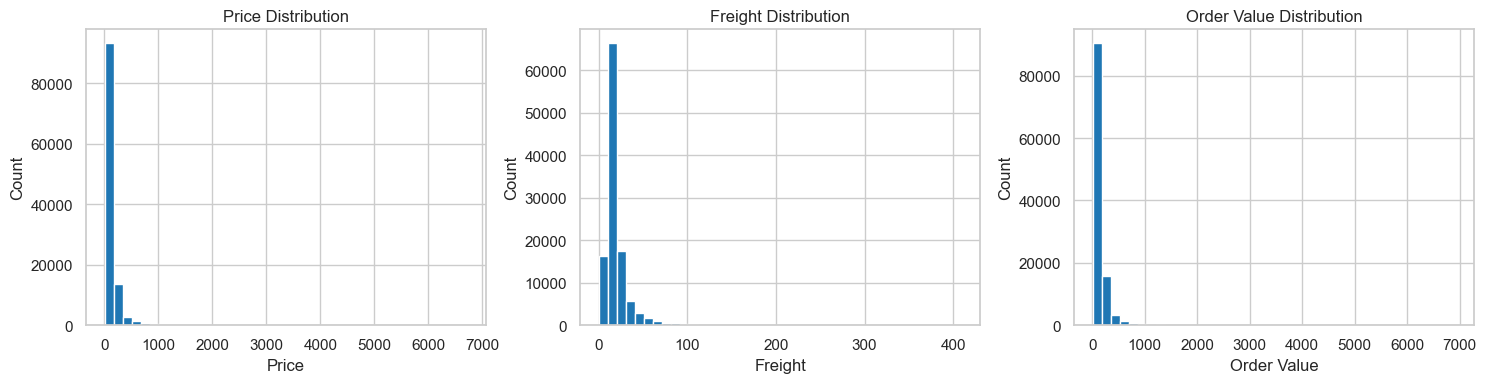

In [16]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
axes[0].hist(base['price'].dropna(), bins=40)
axes[0].set_title('Price Distribution'); axes[0].set_xlabel('Price'); axes[0].set_ylabel('Count')

axes[1].hist(base['freight_value'].dropna(), bins=40)
axes[1].set_title('Freight Distribution'); axes[1].set_xlabel('Freight'); axes[1].set_ylabel('Count')

axes[2].hist(base['order_value'].dropna(), bins=40)
axes[2].set_title('Order Value Distribution'); axes[2].set_xlabel('Order Value'); axes[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

### 6.2 Bar Plot — Top Product Categories by Orders

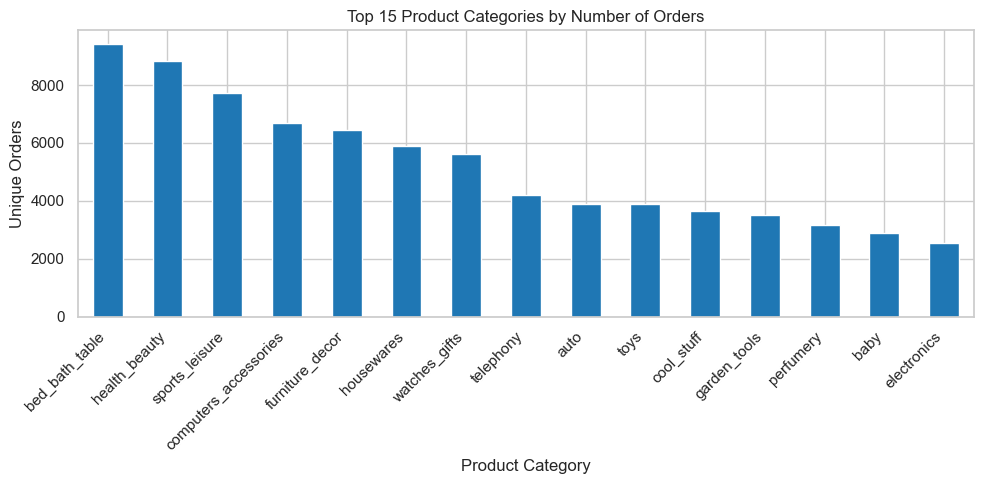

In [17]:
top_cats = (base.groupby('product_category_en')['order_id']
             .nunique()
             .sort_values(ascending=False)
             .head(15))

ax = top_cats.plot(kind='bar')
ax.set_title('Top 15 Product Categories by Number of Orders')
ax.set_xlabel('Product Category')
ax.set_ylabel('Unique Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 6.3 Box Plot — Price by Top Categories

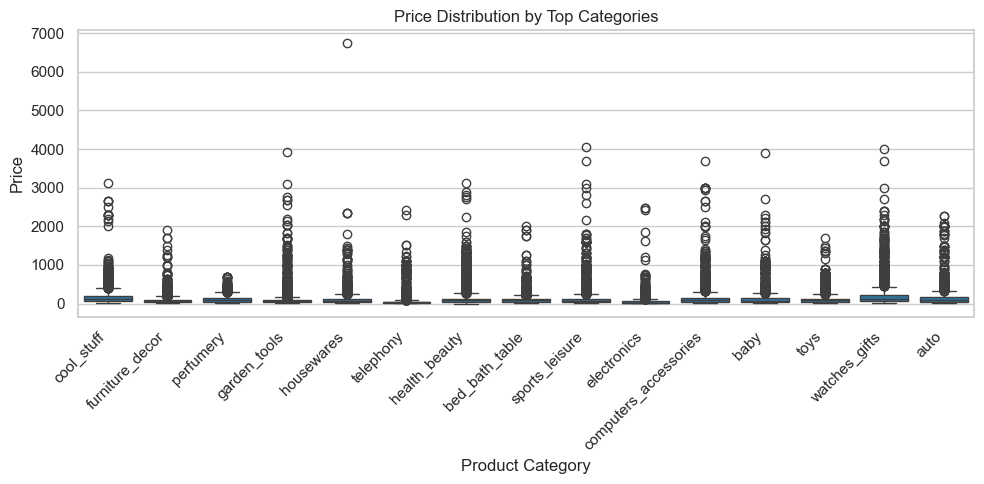

In [18]:
top_cat_names = top_cats.index.tolist()
subset = base[base['product_category_en'].isin(top_cat_names)]
sns.boxplot(data=subset, x='product_category_en', y='price')
plt.title('Price Distribution by Top Categories')
plt.xlabel('Product Category'); plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

### 6.4 Scatter — Price vs Freight (relationship)

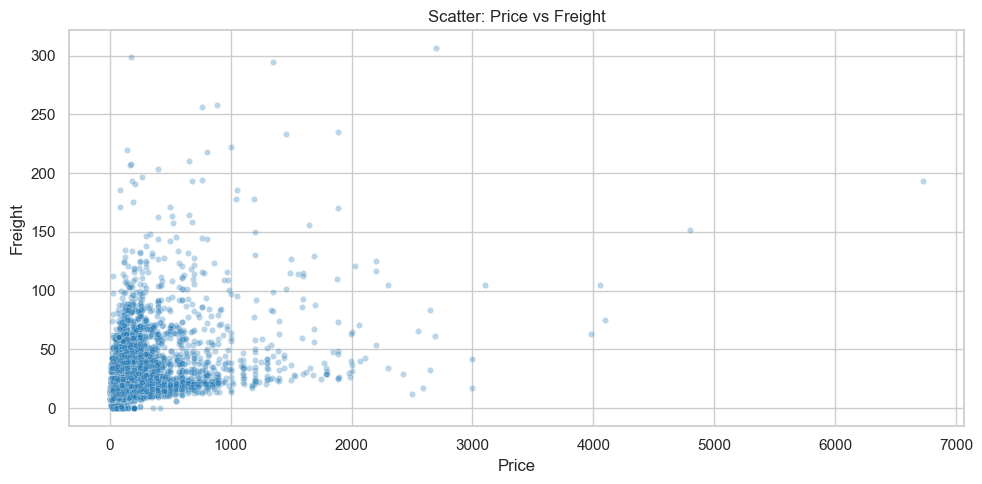

In [19]:
sns.scatterplot(data=base.sample(n=min(20000, len(base)), random_state=42), x='price', y='freight_value', alpha=0.3, s=20)
plt.title('Scatter: Price vs Freight'); plt.xlabel('Price'); plt.ylabel('Freight')
plt.tight_layout(); plt.show()

### 6.5 Correlation Heatmap (numeric features)

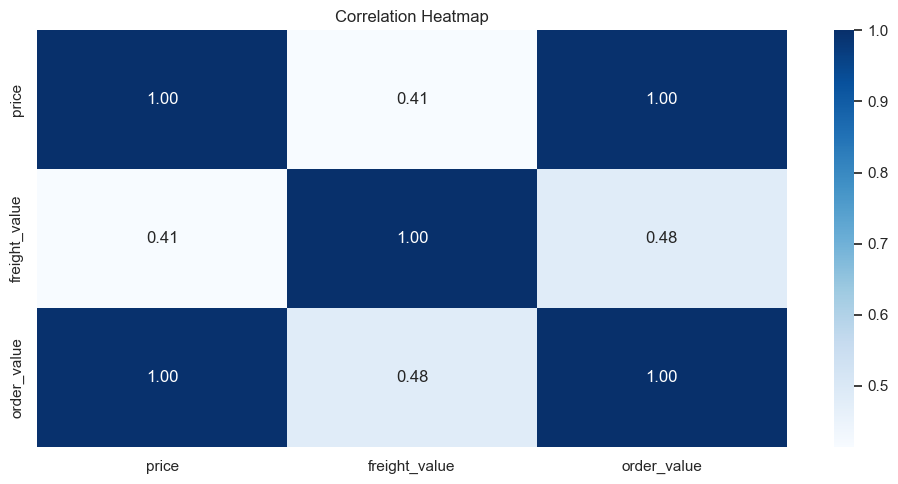

In [20]:
corr = base[['price','freight_value','order_value']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heatmap')
plt.tight_layout(); plt.show()

## 7. Group Analysis & Pivot Tables
### 7.1 Group-by Examples

In [21]:
# Orders & revenue by category
grp_cat = base.groupby('product_category_en').agg(
    orders=('order_id','nunique'),
    items=('product_id','count'),
    revenue=('order_value','sum'),
    avg_order_value=('order_value','mean')
).sort_values('orders', ascending=False).head(20)
grp_cat

,orders,items,revenue,avg_order_value
product_category_en,,,,
bed_bath_table,9417,11115,1241681.72,111.712256
health_beauty,8836,9670,1441248.07,149.043234
sports_leisure,7720,8641,1156656.48,133.856785
computers_accessories,6689,7827,1059272.40,135.335684
furniture_decor,6449,8334,902511.79,108.292751
housewares,5884,6964,778397.77,111.774522
watches_gifts,5624,5991,1305541.61,217.917144
telephony,4199,4545,394883.32,86.883019
auto,3897,4235,685384.32,161.838092


## 8. Time‑Series Trends
Monthly orders and revenue trends using `order_purchase_timestamp`.

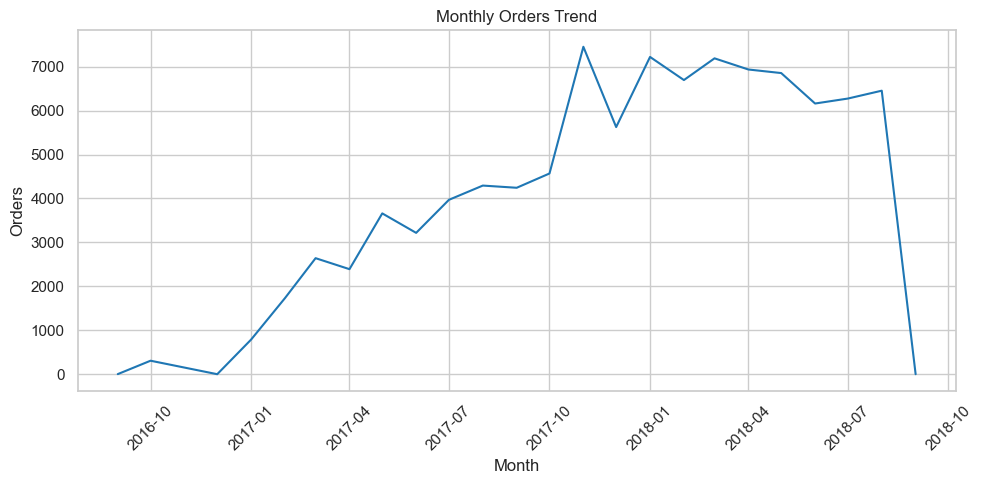

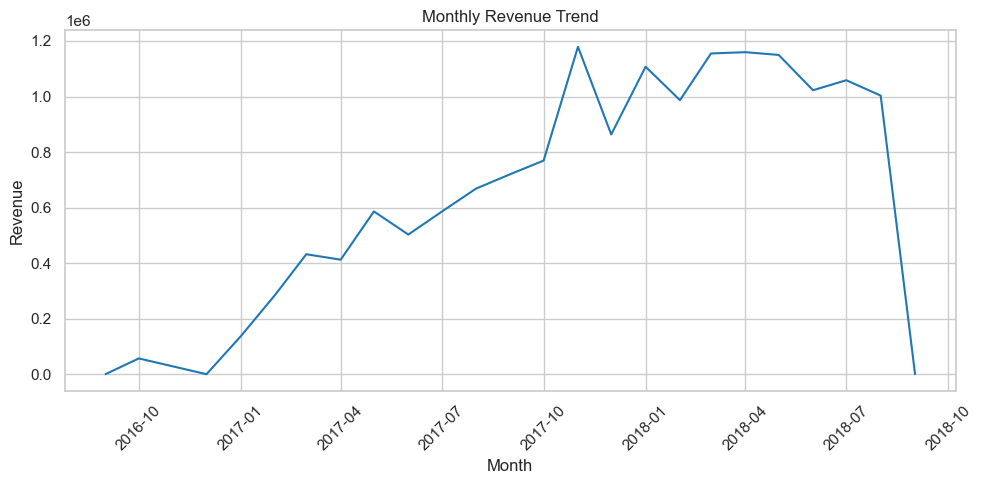

In [22]:
# Monthly trend: orders & revenue
monthly = (base
           .dropna(subset=['order_purchase_timestamp'])
           .assign(order_month=lambda d: d['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp())
           .groupby('order_month')
           .agg(orders=('order_id','nunique'), revenue=('order_value','sum'))
           .reset_index())

fig, ax = plt.subplots()
ax.plot(monthly['order_month'], monthly['orders'])
ax.set_title('Monthly Orders Trend'); ax.set_xlabel('Month'); ax.set_ylabel('Orders')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
ax.plot(monthly['order_month'], monthly['revenue'])
ax.set_title('Monthly Revenue Trend'); ax.set_xlabel('Month'); ax.set_ylabel('Revenue')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

## 9. Advanced Python Techniques
We explicitly include **lambda functions**, a **user-defined function**, and **list comprehensions** to meet the rubric.

In [23]:
# 9.1 Lambda: flag high-value orders
threshold = base['order_value'].quantile(0.9)
base['is_high_value'] = base['order_value'].apply(lambda v: 1 if v>=threshold else 0)
base['is_high_value'].value_counts()

is_high_value
0    101385
1     11265
Name: count, dtype: int64

In [24]:
# 9.2 User-defined function: bucketize order value
def value_bucket(v):
    if pd.isna(v): return 'unknown'
    if v < 50: return 'low'
    if v < 150: return 'medium'
    return 'high'

base['value_bucket'] = base['order_value'].apply(value_bucket)
base['value_bucket'].value_counts()

value_bucket
medium    58900
high      30438
low       23312
Name: count, dtype: int64

In [25]:
# 9.3 List comprehension: list numeric columns with missing values
num_missing_cols = [c for c in num_cols if base[c].isna().any()]
num_missing_cols

[]

## 10. Plot Polish & Annotations
All plots include titles and axis labels. Where helpful, we annotate short text insights.

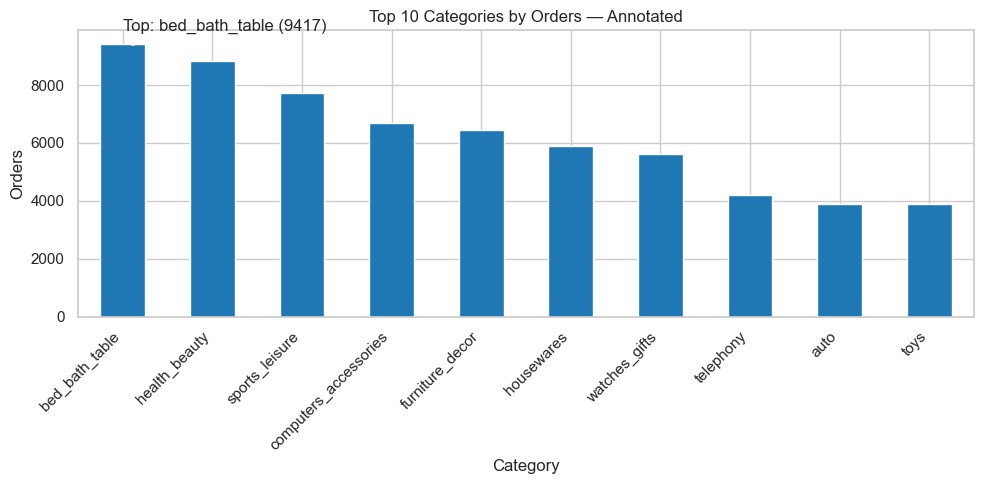

In [26]:
# Example: annotate a bar plot insight
ax = grp_cat['orders'].head(10).plot(kind='bar')
ax.set_title('Top 10 Categories by Orders — Annotated')
ax.set_xlabel('Category'); ax.set_ylabel('Orders')
top_name = grp_cat['orders'].idxmax()
top_val = int(grp_cat['orders'].max())
ax.annotate(f'Top: {top_name} ({top_val})', xy=(0, top_val), xytext=(0, top_val*1.05),
            arrowprops=dict(arrowstyle='->'))
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

## 11. Analyze number of items per order  

**Conclusion:** Understanding the number of items per order helps identify opportunities to increase basket size.  

**Key Findings:**  
- The majority of orders contain **only 1 item**, while a smaller but significant share include **2 or more items**.  
- This pattern suggests customers often make **single-product purchases**, leaving room for **upselling** additional items.  
- Encouraging customers to add more items per order through **bundle offers, discounts, or personalized suggestions** could help increase **average order value**.  



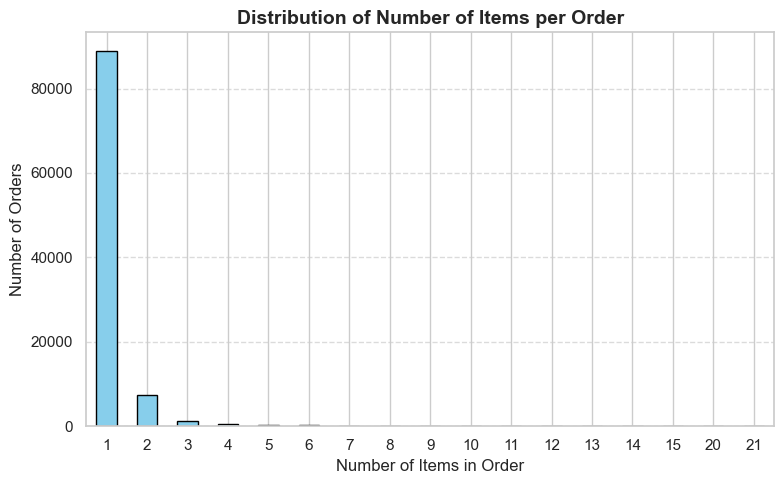

Average items per order: 1.14
Most orders contain: 1 items


In [27]:
items_per_order = order_items.groupby("order_id")["product_id"].count()

# Plot distribution
plt.figure(figsize=(8,5))
items_per_order.value_counts().sort_index().plot(kind='bar', color="skyblue", edgecolor="black")
plt.title("Distribution of Number of Items per Order", fontsize=14, fontweight="bold")
plt.xlabel("Number of Items in Order", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

print("Average items per order:", round(items_per_order.mean(),2))
print("Most orders contain:", items_per_order.mode().values[0], "items")

### 12. Refunds, Cancellations & Disputes  

We analyze problem rates in orders:  
- **Cancellations** → `order_status = canceled`  
- **Disputes** → review score of 1–2  
- **Overall Problems** → either canceled or disputed  

Problem rates are compared across:  
- **Customer states (regions)**  
- **Product categories**  

This highlights where and what types of orders are most prone to issues.



,is_canceled,is_dispute,is_problem
customer_state,,,
RR,1.92,25.00,25.00
AL,0.22,24.67,24.67
MA,0.48,23.33,23.44
RJ,0.62,22.69,22.84
SE,0.26,22.05,22.31
CE,0.47,21.65,21.65
PA,0.37,20.79,20.97
BA,0.42,20.15,20.31
PI,0.73,18.53,18.90


,is_canceled,is_dispute,is_problem
product_category_name_english,,,
security_and_services,0.00,50.00,50.00
fashion_male_clothing,0.76,28.03,28.03
office_furniture,0.06,25.87,25.93
diapers_and_hygiene,2.56,25.64,25.64
fixed_telephony,1.13,25.28,25.28
home_comfort_2,0.00,23.33,23.33
party_supplies,0.00,23.26,23.26
construction_tools_safety,2.58,20.10,22.16
audio,0.27,21.64,21.64


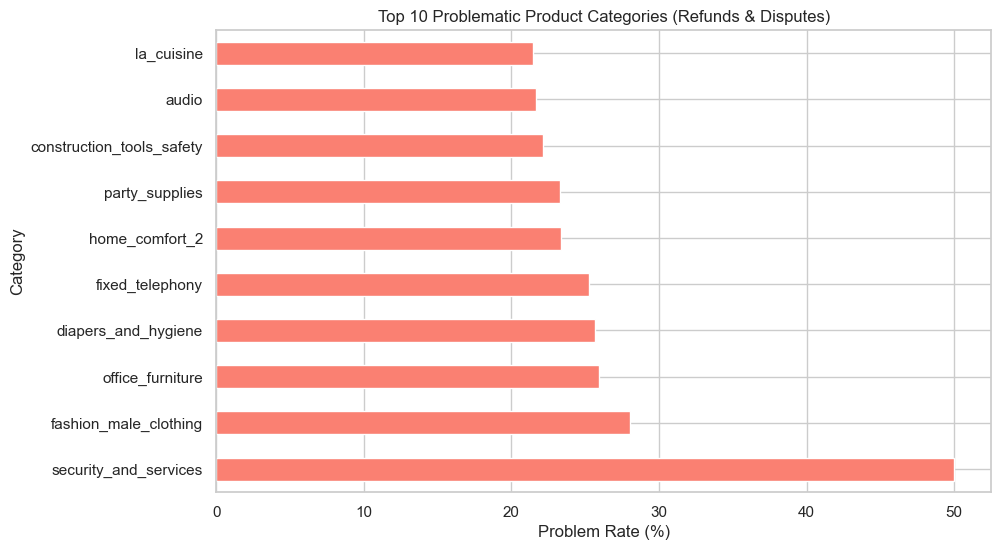

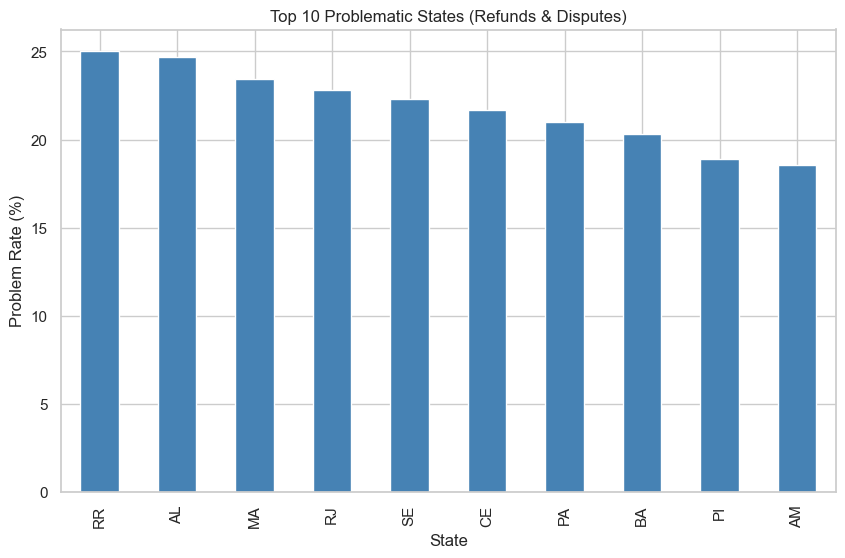

In [28]:
# 12. Refunds, Cancellations & Disputes

# Use dfs[] to avoid overwritten variables
orders_df = dfs["orders"]
customers_df = dfs["customers"]
reviews_df = dfs["order_reviews"]
items_df = dfs["order_items"]
products_df = dfs["products"]
categories_df = dfs["category_names"]

# Merge necessary tables
df_refunds = (
    orders_df
    .merge(customers_df, on="customer_id", how="left")
    .merge(reviews_df, on="order_id", how="left")
    .merge(items_df, on="order_id", how="left")
    .merge(products_df, on="product_id", how="left")
    .merge(categories_df, on="product_category_name", how="left")
)

# Flags
df_refunds["is_canceled"] = (df_refunds["order_status"] == "canceled").astype(int)
df_refunds["is_dispute"] = df_refunds["review_score"].isin([1, 2]).astype(int)
df_refunds["is_problem"] = ((df_refunds["is_canceled"] == 1) | (df_refunds["is_dispute"] == 1)).astype(int)

# Regional stats
region_stats = (
    df_refunds.groupby("customer_state")[["is_canceled","is_dispute","is_problem"]]
    .mean()
    .mul(100)  # convert to %
    .round(2)
    .sort_values("is_problem", ascending=False)
)

# Category stats
category_stats = (
    df_refunds.groupby("product_category_name_english")[["is_canceled","is_dispute","is_problem"]]
    .mean()
    .mul(100)  # convert to %
    .round(2)
    .sort_values("is_problem", ascending=False)
)

# Display summary tables
display(region_stats.head(10))
display(category_stats.head(10))

# Visualization
plt.figure(figsize=(10,6))
category_stats.head(10)["is_problem"].plot(kind="barh", color="salmon")
plt.title("Top 10 Problematic Product Categories (Refunds & Disputes)")
plt.xlabel("Problem Rate (%)")
plt.ylabel("Category")
plt.show()

plt.figure(figsize=(10,6))
region_stats.head(10)["is_problem"].plot(kind="bar", color="steelblue")
plt.title("Top 10 Problematic States (Refunds & Disputes)")
plt.xlabel("State")
plt.ylabel("Problem Rate (%)")
plt.show()


### 13. Customer Demographics by Region

We analyze the distribution of customers across Brazilian states and cities:
- **Orders** → Count of purchases per region
- **Revenue** → Average order value per region

This helps identify high-value geographies for targeted campaigns.

,num_orders,total_revenue,avg_order_value
customer_state,,,
SP,41746,5921678.12,124.800905
RJ,12852,2129681.98,146.078742
MG,11635,1856161.49,141.378741
RS,5466,885826.76,142.073257
PR,5045,800935.44,139.535791
SC,3637,610213.60,146.123946
BA,3380,611506.67,160.965167
DF,2140,353229.44,146.811904
ES,2033,324801.91,143.972478


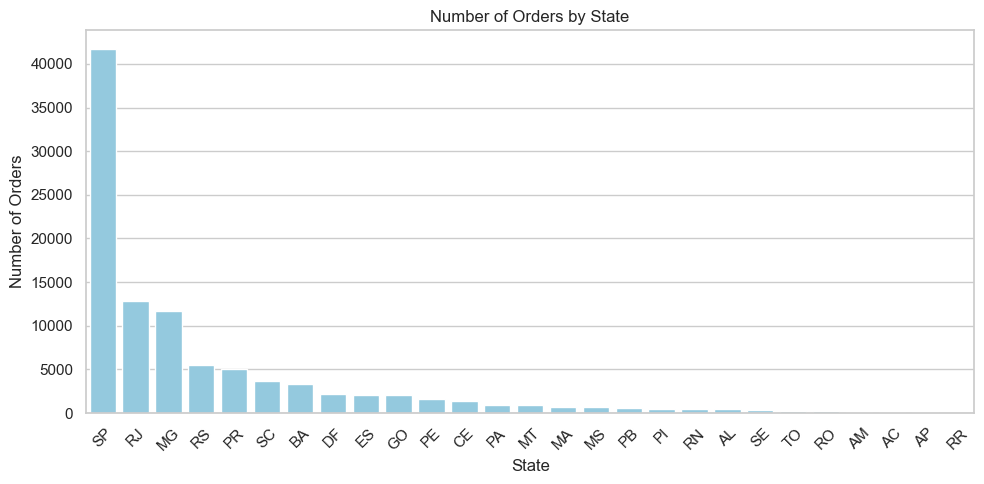

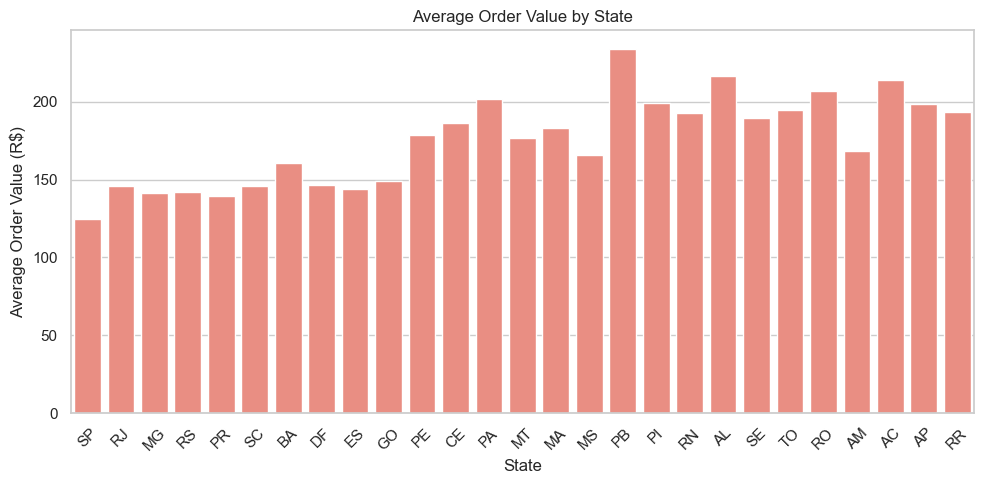

In [29]:
# Merge orders with customers and order items to compute order value
cust_orders = (
    dfs['orders'][['order_id','customer_id','order_purchase_timestamp']]
    .merge(dfs['customers'][['customer_id','customer_state','customer_city']], on='customer_id', how='left')
    .merge(dfs['order_items'].assign(order_value=lambda df: df['price'] + df['freight_value'])[["order_id","order_value"]], on='order_id', how='left')
)

# Orders by state
state_orders = cust_orders.groupby('customer_state').agg(
    num_orders=('order_id','nunique'),
    total_revenue=('order_value','sum'),
    avg_order_value=('order_value','mean')
).sort_values('num_orders', ascending=False)

display(state_orders.head(10))

# Visualization: Number of orders by state
plt.figure(figsize=(10,5))
sns.barplot(x=state_orders.index, y=state_orders['num_orders'], color='skyblue')
plt.title("Number of Orders by State")
plt.xlabel("State")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization: Average order value by state
plt.figure(figsize=(10,5))
sns.barplot(x=state_orders.index, y=state_orders['avg_order_value'], color='salmon')
plt.title("Average Order Value by State")
plt.xlabel("State")
plt.ylabel("Average Order Value (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 14. Age Group Purchase Behavior

We segment customers by age groups and analyze purchase trends:
- **Age groups** → <25, 25–34, 35–44, 45+
- **Metrics** → Average Order Value (AOV), purchase frequency, product categories

This helps guide product recommendations and promotions for each demographic.

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\2955952807.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aov_age = cust_age_orders.groupby('age_group')['order_value'].mean().reset_index()


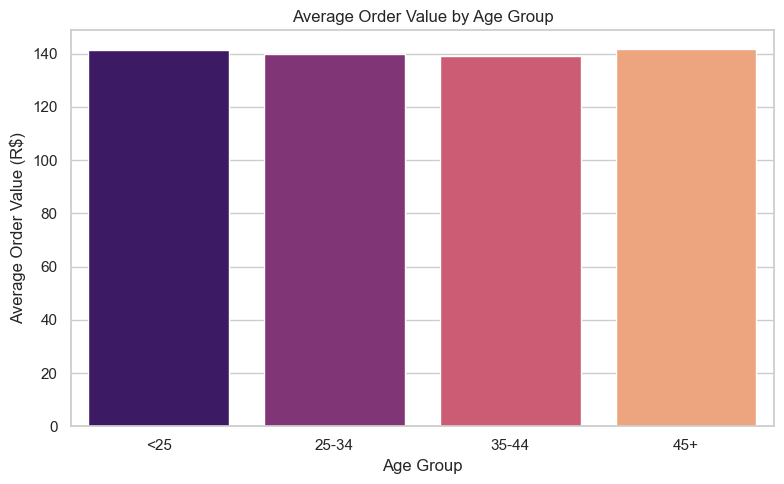

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\2955952807.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_age = cust_age_orders.groupby('age_group')['order_id'].nunique().reset_index(name='num_orders')


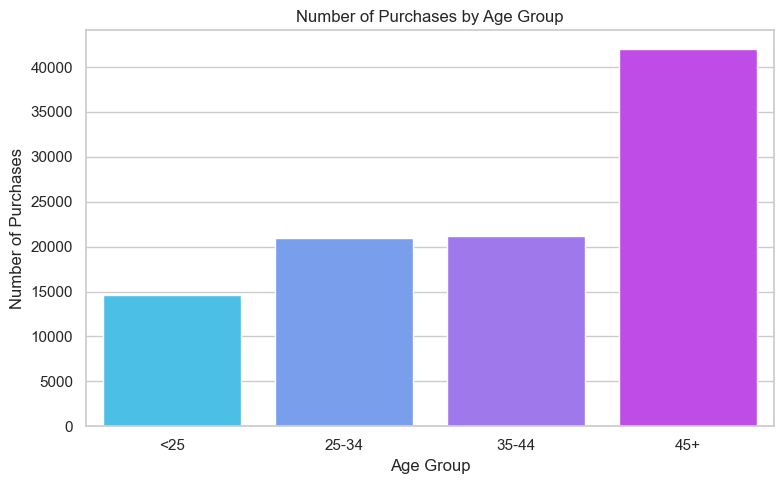

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\2955952807.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cust_age_orders.groupby(['age_group','product_category_name'])
C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\2955952807.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(top_categories_age.groupby('age_group').head(5))


,age_group,product_category_name,count
13,<25,cama_mesa_banho,1690
11,<25,beleza_saude,1356
32,<25,esporte_lazer,1315
54,<25,moveis_decoracao,1183
44,<25,informatica_acessorios,1182
86,25-34,cama_mesa_banho,2334
84,25-34,beleza_saude,1991
105,25-34,esporte_lazer,1900
127,25-34,moveis_decoracao,1737
117,25-34,informatica_acessorios,1702


In [30]:
# simulating 'age' to ensure it exists
if 'age' not in dfs['customers'].columns:
    np.random.seed(42)
    dfs['customers']['age'] = np.random.randint(18, 65, size=len(dfs['customers']))
# Merge orders, items, and customer age correctly
cust_age_orders = (
    dfs['order_items'][['order_id','product_id','price','freight_value']]
    .assign(order_value=lambda df: df['price'] + df['freight_value'])
    .merge(dfs['orders'][['order_id','customer_id']], on='order_id', how='left')
    .merge(dfs['customers'][['customer_id','age']], on='customer_id', how='left')
    .merge(dfs['products'][['product_id','product_category_name']], on='product_id', how='left')
)

# Define age groups
bins = [0,24,34,44,100]
labels = ['<25','25-34','35-44','45+']
cust_age_orders['age_group'] = pd.cut(cust_age_orders['age'], bins=bins, labels=labels)

# Average Order Value per age group
aov_age = cust_age_orders.groupby('age_group')['order_value'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='order_value', data=aov_age, hue='age_group', palette='magma', dodge=False, legend=False)
plt.title("Average Order Value by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Order Value (R$)")
plt.tight_layout()
plt.show()

# Purchase frequency per age group
freq_age = cust_age_orders.groupby('age_group')['order_id'].nunique().reset_index(name='num_orders')
plt.figure(figsize=(8,5))
sns.barplot(x='age_group', y='num_orders', data=freq_age, hue='age_group', palette='cool', dodge=False, legend=False)
plt.title("Number of Purchases by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Purchases")
plt.tight_layout()
plt.show()

# Top product categories per age group
top_categories_age = (
    cust_age_orders.groupby(['age_group','product_category_name'])
    .size().reset_index(name='count')
    .sort_values(['age_group','count'], ascending=[True,False])
)
display(top_categories_age.groupby('age_group').head(5))

##  14. High-Value, Low-Value, Medium-Value Spenders

We are analyzing the customers by clustering them into high-value, low-value and medium-value spenders
1. Comparing them across product category.
2. Analyzing the frequencies of these spenders

This analysis helps to plan the offers that can be made available as per the customer frequency and their spending pattern

In [31]:
# Filling Null Values for payment_value with mode value
base['ord_payment']=base.payment_value.fillna(base.payment_value.mode())

# Purchase category values
def payment_cat(pay_val):
    if pay_val <= 3000 :
        return 'Lower purchase value'
    elif (pay_val > 3000) and (pay_val <= 8000) :
        return 'Medium purchase value'
    elif pay_val > 8000 :
        return 'Higher purchase value'

base['payment_cat']=base['ord_payment'].apply(lambda x: payment_cat(x) if pd.notnull(x) else 'Unknown')
display(base.payment_cat.value_counts())


payment_cat
Lower purchase value     112555
Medium purchase value        84
Higher purchase value         8
Unknown                       3
Name: count, dtype: int64

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\2442537350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


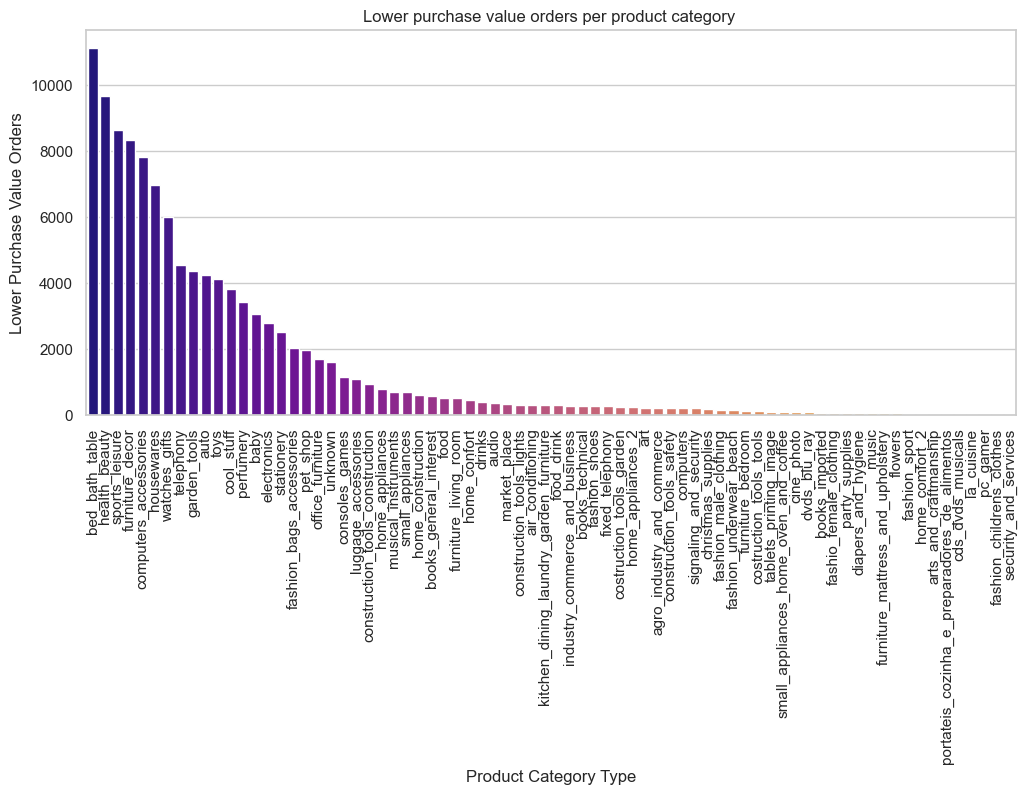

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\2442537350.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


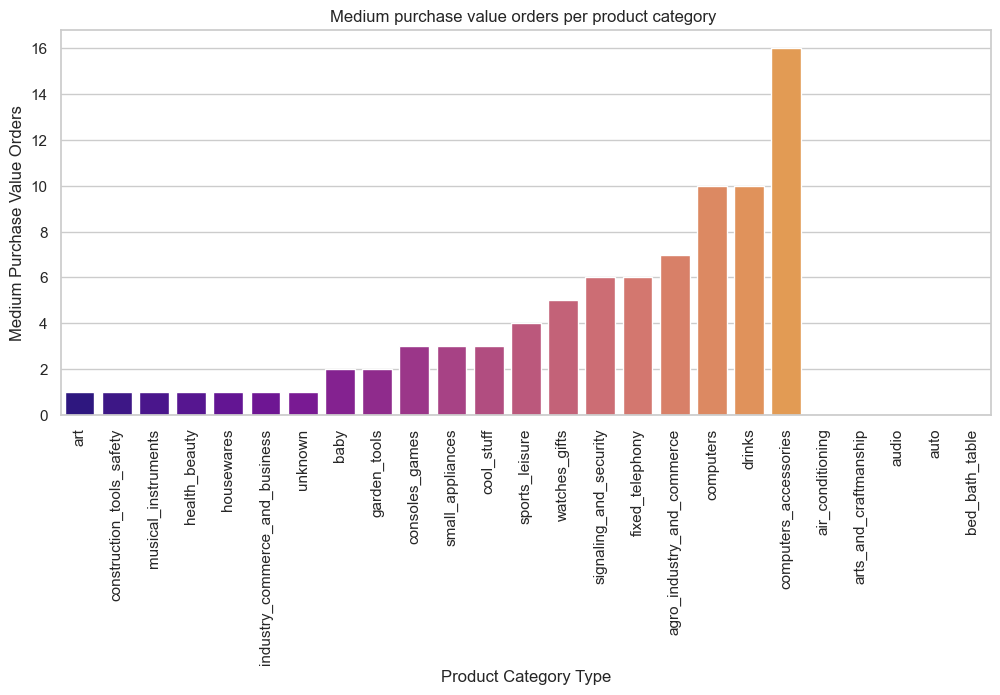

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\2442537350.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


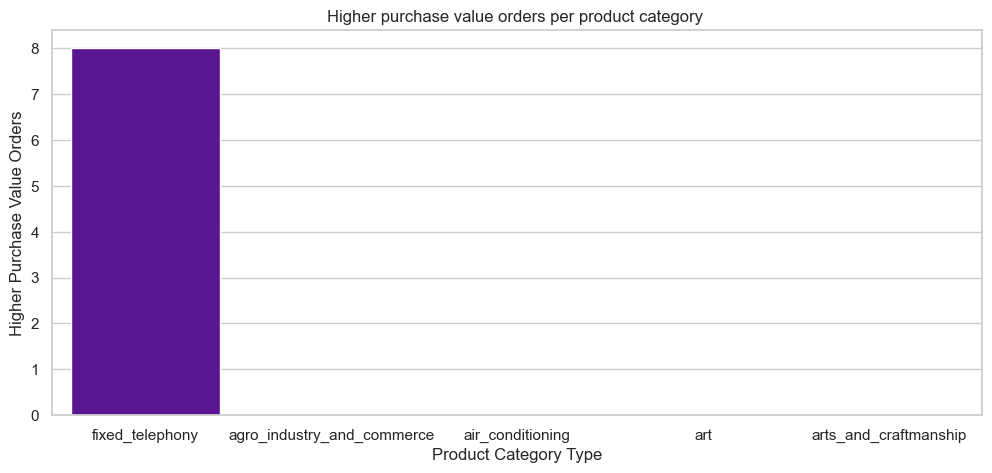

In [32]:
payCat_proCat = base.groupby('product_category_en')['payment_cat'].value_counts().unstack(level=1).reset_index(names='product_cat')

low_pro_cat = payCat_proCat.sort_values(by='Lower purchase value', ascending=False)
plt.figure(figsize=(12,5))
sns.barplot(
    y=low_pro_cat['Lower purchase value'],
    x=low_pro_cat.product_cat,
    palette='plasma',
    dodge=False
)
plt.title("Lower purchase value orders per product category ")
plt.xticks(rotation=90)
plt.xlabel("Product Category Type")
plt.ylabel("Lower Purchase Value Orders")
plt.show()

med_pro_cat = payCat_proCat.sort_values(by='Medium purchase value', ascending=True).head(25)
plt.figure(figsize=(12,5))
sns.barplot(
    y=med_pro_cat['Medium purchase value'],
    x=med_pro_cat.product_cat,
    palette='plasma',
    dodge=False
)
plt.title("Medium purchase value orders per product category ")
plt.xticks(rotation=90)
plt.xlabel("Product Category Type")
plt.ylabel("Medium Purchase Value Orders")
plt.show()

high_pro_cat = payCat_proCat.sort_values(by='Higher purchase value', ascending=True).head(5)
plt.figure(figsize=(12,5))
sns.barplot(
    y=high_pro_cat['Higher purchase value'],
    x=high_pro_cat.product_cat,
    palette='plasma',
    dodge=False
)
plt.title("Higher purchase value orders per product category ")
plt.xticks(rotation=0)
plt.xlabel("Product Category Type")
plt.ylabel("Higher Purchase Value Orders")
plt.show()

payment_cat,Frequency,Higher purchase value,Lower purchase value,Medium purchase value,Unknown
0,1,NaN,88826.0,37.0,NaN
1,2,NaN,15024.0,8.0,NaN
2,3,NaN,3960.0,3.0,3.0
3,4,NaN,2012.0,8.0,NaN
4,5,NaN,1020.0,NaN,NaN
5,6,NaN,1170.0,18.0,NaN
6,7,NaN,154.0,NaN,NaN
7,8,8.0,56.0,NaN,NaN
8,9,NaN,27.0,NaN,NaN
9,10,NaN,70.0,10.0,NaN


C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\1329606145.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=freq_pay_cat['Lower purchase value'],x=freq_pay_cat.Frequency,palette='plasma',dodge=False,ax=axes[0])
C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\1329606145.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=freq_pay_cat['Medium purchase value'],x=freq_pay_cat.Frequency,palette='plasma',dodge=False,ax=axes[1])


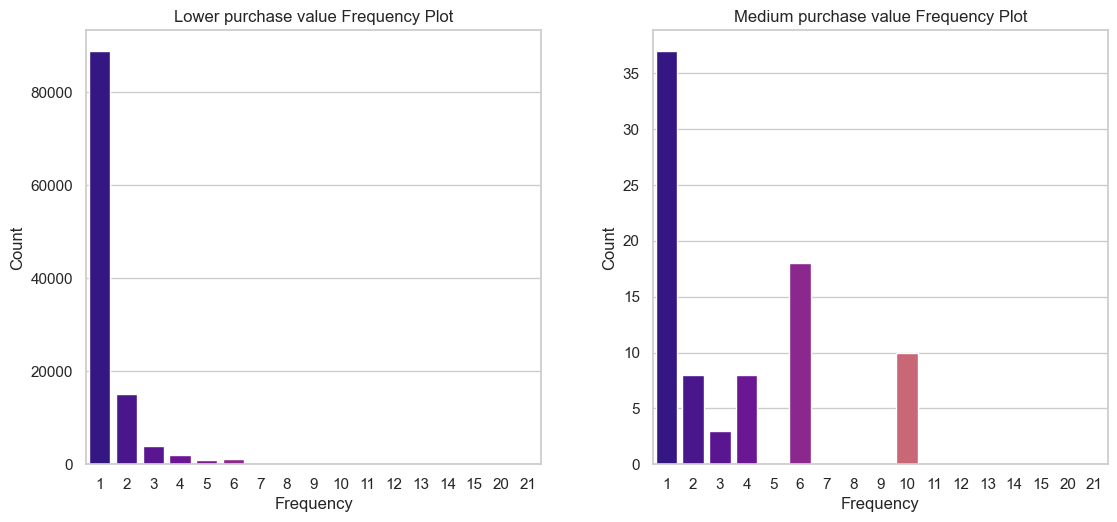

In [33]:
freq = base.groupby('customer_id').agg(Frequency=('order_id','count')).reset_index(names='customer_id')

freq_base = pd.merge(left=freq,right=base,how='inner',left_on='customer_id',right_on='customer_id')

freq_pay_cat = freq_base.groupby('payment_cat')['Frequency'].value_counts().unstack(level=0).reset_index(names='Frequency')
display(freq_pay_cat)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.tight_layout(pad=4.0) 

sns.barplot(y=freq_pay_cat['Lower purchase value'],x=freq_pay_cat.Frequency,palette='plasma',dodge=False,ax=axes[0])
axes[0].set_title("Lower purchase value Frequency Plot")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Count")

sns.barplot(y=freq_pay_cat['Medium purchase value'],x=freq_pay_cat.Frequency,palette='plasma',dodge=False,ax=axes[1])
axes[1].set_title("Medium purchase value Frequency Plot")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Count")

plt.show()

Conclusions
1. Throughout the 3 years, Low value spenders have the highest frequency of 6, where as the highest frequency of medium value spenders is around 10
2. Most customers have frequency of 1
3. Low value spenders buy most products from bed_bath_table followed by health_beauty
4. High value spenders bought the products from fixed_telephony
5. Medium value spenders bought the most products from computers_accessories followed by computers and drinks

## 15. Payment Method Preferences

We are analyzing the payment types
1. For the delivered and cancelled orders
2. Accross the year
3. For Medium Purchase Values

These analysis helps to plan the offers that can be made available on the basis of payment type

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\1409334642.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


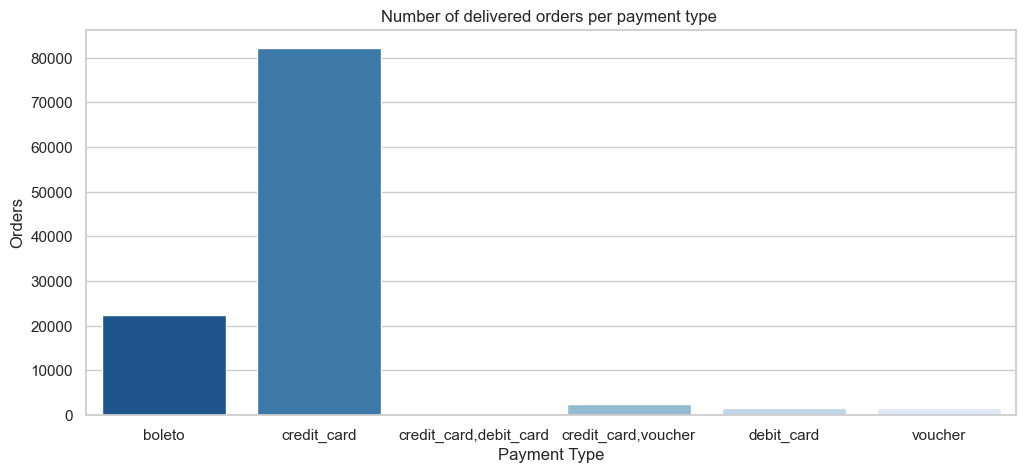

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\1409334642.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


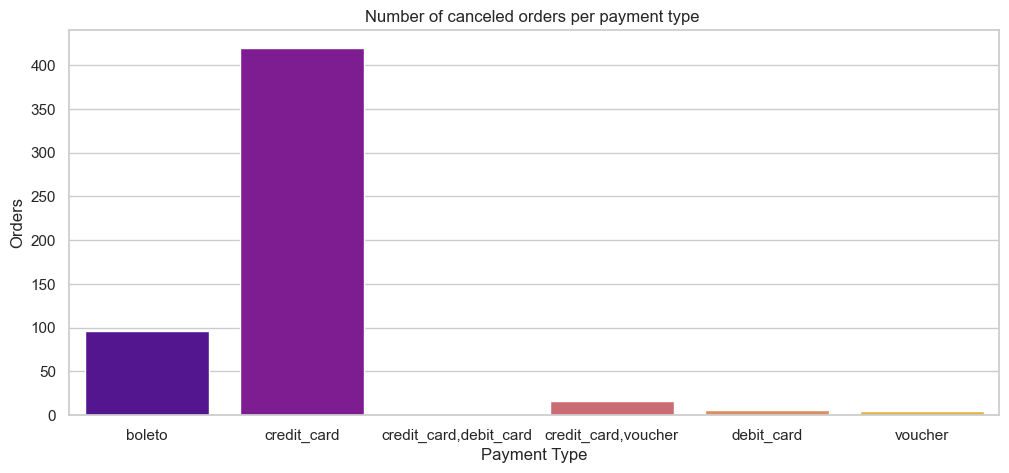

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\1409334642.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


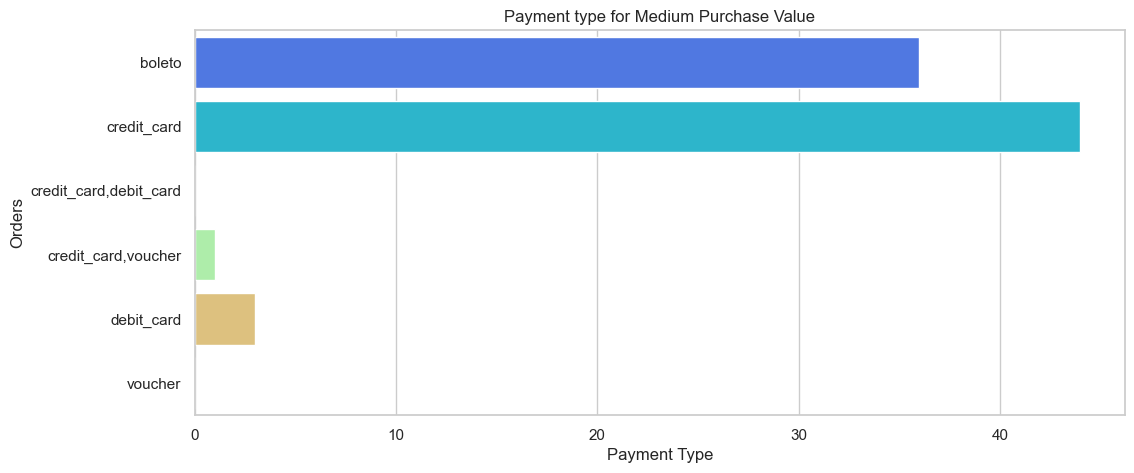

payment_type,order_year,boleto,credit_card,"credit_card,debit_card","credit_card,voucher",debit_card,voucher
0,2016,71.0,284.0,NaN,5.0,2.0,5.0
1,2017,10927.0,37385.0,NaN,1288.0,465.0,799.0
2,2018,11869.0,46278.0,1.0,1194.0,1222.0,852.0


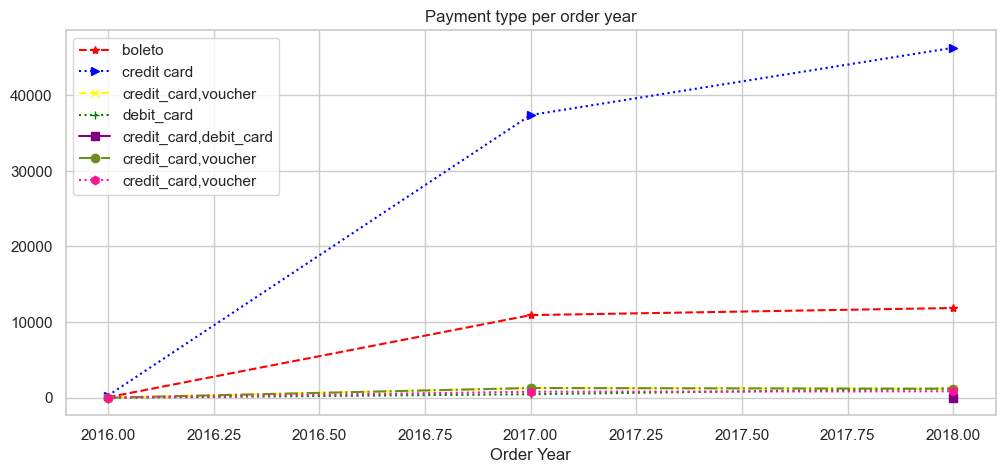

In [34]:
# Order Status - delivered per payment type
pay_delivered = base.groupby('order_status')['payment_type'].value_counts().unstack(level=0).reset_index(names='payment_type')
plt.figure(figsize=(12,5))
sns.barplot(
    y=pay_delivered.delivered,
    x=pay_delivered.payment_type,
    palette='Blues_r',
    dodge=False
)
plt.title("Number of delivered orders per payment type ")
plt.xticks(rotation=0)
plt.xlabel("Payment Type")
plt.ylabel("Orders")
plt.show()

# Order Status - cancelled per payment type
pay_cancelled = base.groupby('order_status')['payment_type'].value_counts().unstack(level=0).reset_index(names='payment_type')
plt.figure(figsize=(12,5))
sns.barplot(
    y=pay_delivered.canceled,
    x=pay_delivered.payment_type,
    palette='plasma',
    dodge=False
)
plt.title("Number of canceled orders per payment type ")
plt.xticks(rotation=0)
plt.xlabel("Payment Type")
plt.ylabel("Orders")
plt.show()

# Medium Purchase Value category per payment type
purchase_payment=pd.crosstab(base.payment_type, base.payment_cat).reset_index(names='payment_method')
plt.figure(figsize=(12,5))
sns.barplot(
    y=purchase_payment.payment_method,
    x=purchase_payment['Medium purchase value'],
    palette='rainbow',
    dodge=False
)
plt.title("Payment type for Medium Purchase Value")
plt.xticks(rotation=0)
plt.xlabel("Payment Type")
plt.ylabel("Orders")
plt.show()

# Payment types used over years
year_payment_type = base.groupby('payment_type')['order_year'].value_counts().unstack(level=0).reset_index(names='order_year')
display(year_payment_type)
plt.figure(figsize=(12,5))
plt.plot(year_payment_type.order_year,year_payment_type.boleto,marker='*',color='red',linestyle='dashed',label='boleto') 
plt.plot(year_payment_type.order_year,year_payment_type.credit_card,marker='>',color='blue',linestyle='dotted',label='credit card')
plt.plot(year_payment_type.order_year,year_payment_type['credit_card,voucher'],marker='x',color='yellow',linestyle='dashed',label='credit_card,voucher') 
plt.plot(year_payment_type.order_year,year_payment_type.debit_card,marker='+',color='green',linestyle='dotted',label='debit_card')
plt.plot(year_payment_type.order_year,year_payment_type['credit_card,debit_card'],marker='s',color='purple',linestyle='solid',label='credit_card,debit_card')
plt.plot(year_payment_type.order_year,year_payment_type['credit_card,voucher'],marker='o',color='olivedrab',linestyle='dashdot',label='credit_card,voucher') 
plt.plot(year_payment_type.order_year,year_payment_type['voucher'],marker='h',color='deeppink',linestyle='dotted',label='credit_card,voucher') 

plt.legend()

plt.xlabel('Order Year')

plt.title('Payment type per order year')

plt.show()

Conclusions:
1. Highest number of payments for delivered and cancelled orders are made with credit card followed by boleto
2. Medium Purchase Value customers mostly use credit card
3. Payments made from credit cards and boleto have increased over the years, where as debit_card and voucher remains around the same percentage

# 16. Order Delivery Performance

We now turn to the analysis of Olist’s delivery performance.  
This section explores delivery times, delays, customer reviews, and responsibility for late deliveries.


In [35]:
orders['order_purchase_timestamp']      = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], errors='coerce')
orders['order_delivered_carrier_date']  = pd.to_datetime(orders['order_delivered_carrier_date'], errors='coerce')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], errors='coerce')

deliver_df = orders.copy()

deliver_df['delivered_days'] = (deliver_df['order_delivered_customer_date'] - deliver_df['order_purchase_timestamp']).dt.days
deliver_df['days_est_vs_deliver'] = (deliver_df['order_estimated_delivery_date'] - deliver_df['order_delivered_customer_date']).dt.days
deliver_df['days_limit_vs_deliver_carrier'] = (deliver_df['order_delivered_carrier_date'] - deliver_df['order_purchase_timestamp']).dt.days

deliver_df['seller_to_carrier'] = np.where(
    deliver_df['days_limit_vs_deliver_carrier'] < 0,
    'late deliver to carrier',
    'in time deliver to carrier'
)

deliver_df['est_to_deliver'] = np.where(
    deliver_df['days_est_vs_deliver'] < 0,
    'late deliver',
    'on time deliver'
)

conditions = [
    (deliver_df['days_est_vs_deliver'] < -10),
    (deliver_df['days_est_vs_deliver'] <= -5),
    (deliver_df['days_est_vs_deliver'] < 0)
]
choices = ['late over 10 days','late 5–10 days','late under 5 days']
deliver_df['est_to_deliver_detail'] = np.select(conditions, choices, default='on time deliver')

# merge with reviews (avg score per order)
reviews_unique = order_reviews.pivot_table(values='review_score', index='order_id', aggfunc='mean').reset_index()
deliver_df = deliver_df.merge(reviews_unique, how="left", on='order_id')

# drop NaNs in delivery dates
deliver_df = deliver_df.dropna(subset=['order_delivered_customer_date','order_delivered_carrier_date'])

 **16.1 Range of Delivered Days**

How long does it typically take for orders to be delivered?  
We calculate the distribution of delivery days across all orders.


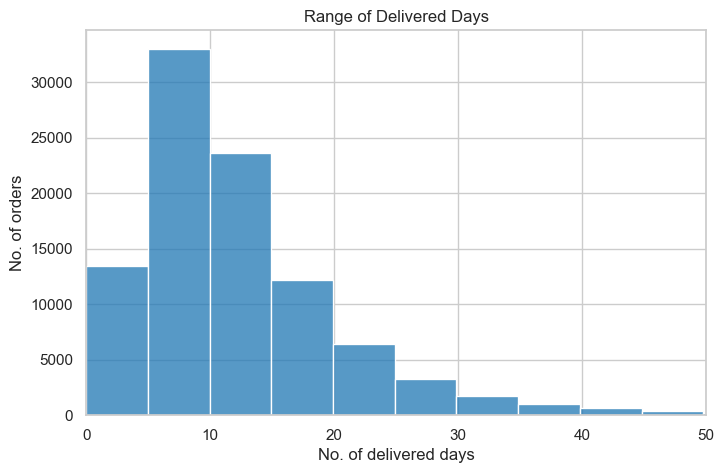

In [36]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(deliver_df[['order_id','delivered_days']].drop_duplicates(),
             x='delivered_days', binwidth=5, ax=ax)
ax.set(title='Range of Delivered Days', xlabel='No. of delivered days', ylabel='No. of orders')
ax.set_xlim(0,50)
plt.show()

**16.2 Delivered Days by Top Product Categories**

Delivery time may vary across product categories.  
Here, we compare the delivery durations for some of the most popular categories such as health, beauty, furniture, and electronics.


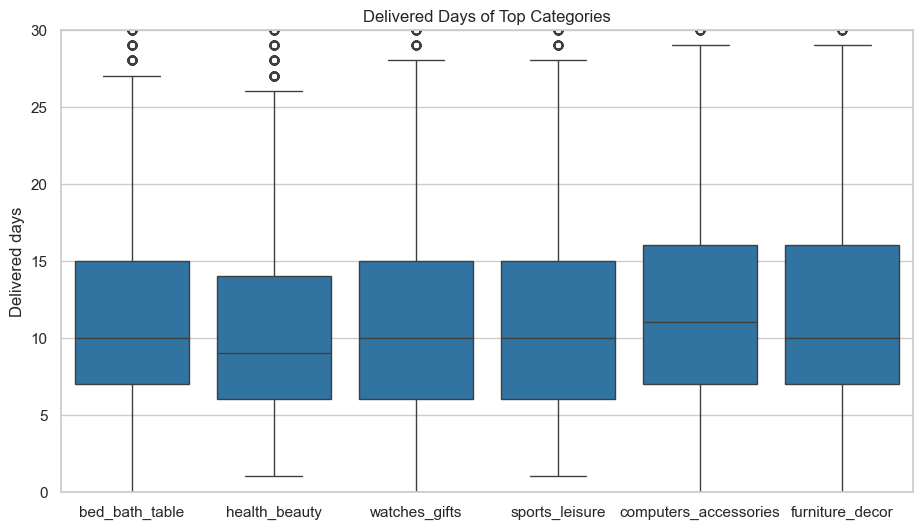

In [37]:
deliver_items = (
    order_items
      .merge(products[['product_id','product_category_name']], on='product_id', how='left')
      .merge(category_names, on='product_category_name', how='left')
      .merge(deliver_df[['order_id','delivered_days']], on='order_id', how='inner')
)

# Use the English names for filtering
top_cats_en = ['bed_bath_table','health_beauty','watches_gifts',
               'sports_leisure','computers_accessories','furniture_decor']

deliver_top = deliver_items[deliver_items['product_category_name_english'].isin(top_cats_en)]

fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(
    data=deliver_top,
    x="product_category_name_english", 
    y="delivered_days",
    order=top_cats_en,
    ax=ax
)
ax.set(title="Delivered Days of Top Categories", xlabel=None, ylabel="Delivered days")
ax.set_ylim(0,30)
plt.show()


 **16.3. Actual vs Estimated Delivery**

Were orders delivered on time?  
We compare actual delivery dates with estimated delivery dates to see the proportion of late vs. on-time deliveries.


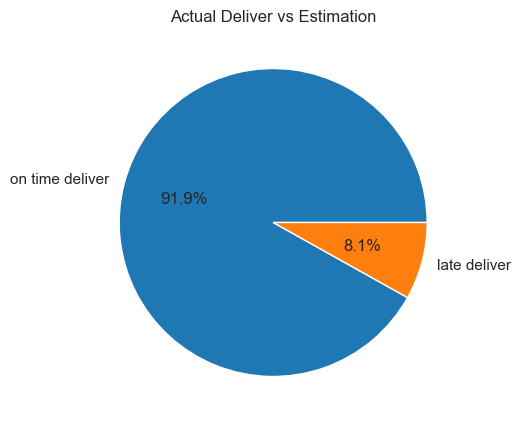

In [38]:
dlv = deliver_df.groupby('est_to_deliver')['order_id'].nunique().sort_values(ascending=False)
dlv.plot.pie(autopct='%1.1f%%', figsize=(5,5), ylabel='', title='Actual Deliver vs Estimation')
plt.show()

**16.4. Breakdown of Late Deliveries**

Not all late orders are equal.  
This section classifies late deliveries into three buckets:
- Late under 5 days  
- Late between 5–10 days  
- Late over 10 days


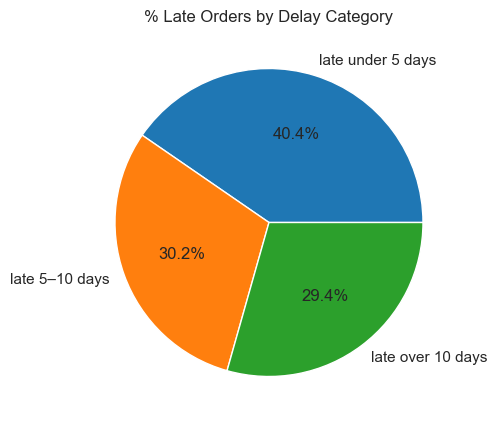

In [39]:
late_df = deliver_df[deliver_df['est_to_deliver']=='late deliver']
late_break = late_df.groupby('est_to_deliver_detail')['order_id'].nunique().sort_values(ascending=False)
late_break.plot.pie(autopct='%1.1f%%', figsize=(5,5), ylabel='', title='% Late Orders by Delay Category')
plt.show()

**16.5. Review Score vs Delivery Status**

How do delivery times impact customer satisfaction?  
We compare average review scores between on-time deliveries and late deliveries.


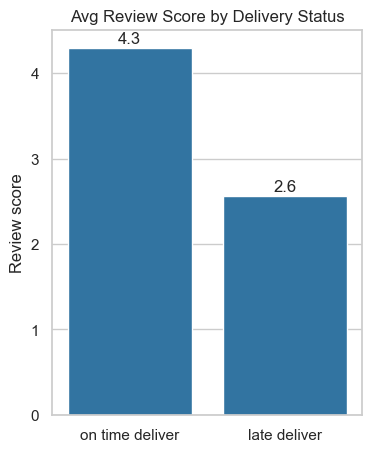

In [40]:
reviews = deliver_df[['order_id','est_to_deliver','review_score']].dropna().drop_duplicates()
avg_reviews = reviews.groupby('est_to_deliver')['review_score'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(x=avg_reviews.index, y=avg_reviews.values, ax=ax)
ax.set(title="Avg Review Score by Delivery Status", xlabel=None, ylabel="Review score")
for i, v in enumerate(avg_reviews.values):
    ax.text(i, v+0.05, f"{v:.1f}", ha='center')
plt.show()


**16.6. Seller vs Carrier Responsibility**

Delays can be caused either by sellers delivering late to carriers,  
or by carriers taking too long to deliver to customers.  
This section breaks down late deliveries to see where the main responsibility lies.


In [41]:
deadline = (order_items
            .groupby('order_id', as_index=False)['shipping_limit_date']
            .max()
            .rename(columns={'shipping_limit_date': 'shipping_limit_deadline'}))

deliver_ex = deliver_df.merge(deadline, on='order_id', how='left')

# Days over/under shipping limit
deliver_ex['days_limit_vs_deliver_carrier'] = (
    deliver_ex['order_delivered_carrier_date'] - deliver_ex['shipping_limit_deadline']
).dt.days

# Classification
deliver_ex['seller_to_carrier'] = np.where(
    deliver_ex['days_limit_vs_deliver_carrier'] > 0,
    'late deliver to carrier',
    'in time deliver to carrier'
)

# Focus only on late orders
late_ex = deliver_ex[deliver_ex['est_to_deliver'] == 'late deliver']

# Aggregate unique late orders by responsibility
carrier_share = (late_ex.groupby('seller_to_carrier')['order_id']
                 .nunique()
                 .rename('unique_orders')
                 .sort_values(ascending=False))

# Plot
carrier_share.plot.pie(
    autopct='%1.1f%%',
    figsize=(5,5),
    ylabel='',
    title='% Late vs In-time Deliver to Carrier (unique orders)'
)
plt.show()

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\3065377758.py:10: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  deliver_ex['order_delivered_carrier_date'] - deliver_ex['shipping_limit_deadline']


TypeError: unsupported operand type(s) for -: 'Timestamp' and 'str'

**16.7. Sellers with Highest Late Delivery Percentage**

Which sellers are most often responsible for late deliveries?  
We identify sellers with at least the average number of orders and rank them by their percentage of late orders.


In [ ]:
deliver_seller = (
    deliver_df[['order_id','seller_to_carrier']]
    .merge(order_items[['order_id','seller_id']], on='order_id', how='left')
    .drop_duplicates()
)

# Count unique orders per seller
seller_pv = deliver_seller.pivot_table(values='order_id', index='seller_id', aggfunc='nunique').reset_index()
seller_pv.rename(columns={"order_id": "unique_order"}, inplace=True)

# Count late orders per seller
seller_late = (deliver_seller[deliver_seller['seller_to_carrier']=='late deliver to carrier']
               .pivot_table(values='order_id', index='seller_id', aggfunc='nunique')
               .reset_index())
seller_late.rename(columns={"order_id": "late_order"}, inplace=True)

# Merge summary
seller_summary = seller_pv.merge(seller_late, how="left", on='seller_id')
seller_summary.fillna(0, inplace=True)
seller_summary["percent_late_order"] = seller_summary.late_order * 100 / seller_summary.unique_order

# Sort by % late orders
seller_summary.sort_values("percent_late_order", ascending=False, inplace=True)

# Average orders per seller
avg_ord_per_seller = seller_pv['unique_order'].mean()

# Sellers with at least average number of orders, ranked by lateness
seller_top = seller_summary[seller_summary['unique_order'] >= avg_ord_per_seller]
seller_top_10 = seller_top.head(10).set_index('seller_id')

# Pretty display
seller_top_10.style.background_gradient(cmap="Reds")


17. **Understanding the Trend of Orders by Month, Year and Quarter**

**17.1 Order Trend YOY and Monthly**

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\4132890296.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


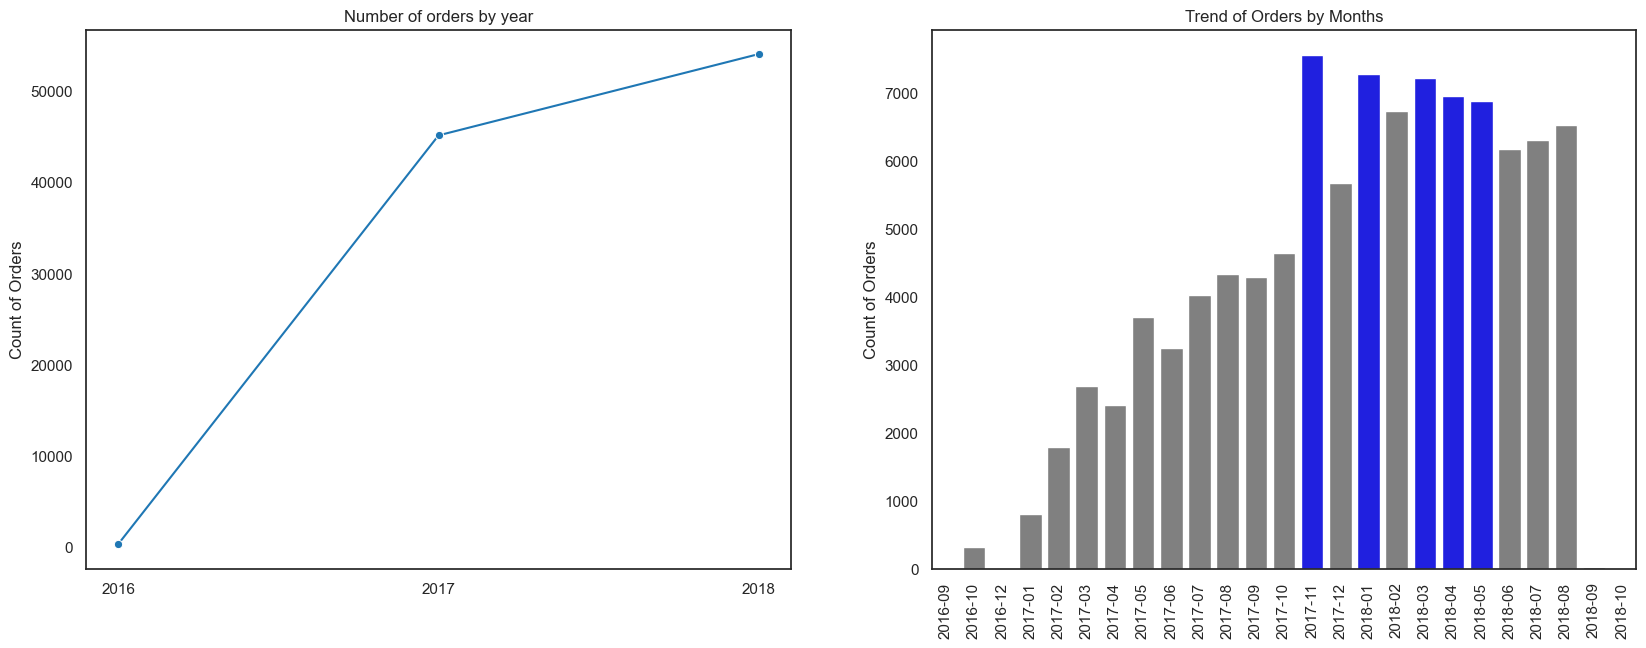

In [46]:
customer_orders = customers.merge(orders[['customer_id','order_id','order_purchase_timestamp']], on='customer_id', how='inner')
fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.set_style("white")  
orders_count_by_years = customer_orders.groupby(pd.to_datetime(customer_orders['order_purchase_timestamp']).dt.year).agg({'order_id':'nunique'}).reset_index(names='year')
orders_count_by_years = pd.DataFrame(orders_count_by_years)

ax1 = sns.lineplot(data=orders_count_by_years, x=orders_count_by_years['year'].astype('str'), y='order_id', ax=ax[0], marker="o" )
ax1.title.set_text('Number of orders by year')
ax1.set_ylabel("Count of Orders")
ax1.set_xlabel("")

#order counut by month 

orders_count_by_months = customer_orders.groupby(pd.to_datetime(customer_orders['order_purchase_timestamp']).dt.to_period('M')).agg({'order_id':'nunique'}).reset_index(names='month')
orders_count_by_months = pd.DataFrame(orders_count_by_months)


# Find top 5 order_id values
top5_values = orders_count_by_months.nlargest(5, "order_id")["order_id"].tolist()

# Create a color column
orders_count_by_months["color"] = np.where(
    orders_count_by_months["order_id"].isin(top5_values),
    "blue",  # top 5
    "gray"  # others
)

# Use the color column as palette
palette_dict = dict(zip(orders_count_by_months["month"].astype(str), orders_count_by_months["color"]))

# Plot with palette
ax = sns.barplot(
    data=orders_count_by_months,
    x="month",
    y="order_id",
    palette=palette_dict,
    ax=ax[1]
)

ax.tick_params(axis='x', rotation=90)
ax.title.set_text("Trend of Orders by Months")
ax.set_ylabel("Count of Orders")
ax.set_xlabel("")
plt.show()

**17.2 Months where Orders are above Median**

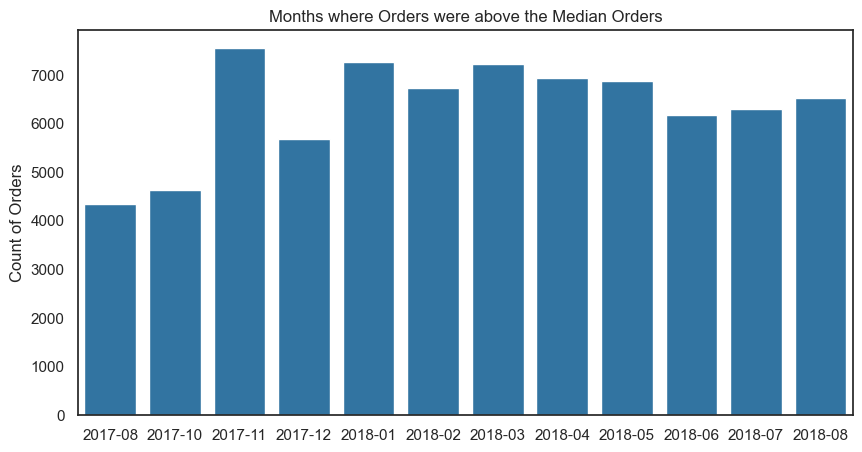

In [45]:

orders_count_by_months["order_id"].median()
above_median = orders_count_by_months[orders_count_by_months["order_id"] >orders_count_by_months["order_id"].median()]
sns.barplot(above_median, x= 'month', y = 'order_id')
plt.ylabel("Count of Orders")
plt.xlabel("")
plt.title("Months where Orders were above the Median Orders")
plt.show()

**17.3 Trend of Orders on Week day Basis**

C:\Users\OmkarBhalerao\AppData\Local\Temp\ipykernel_27044\2957537106.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('weekday')


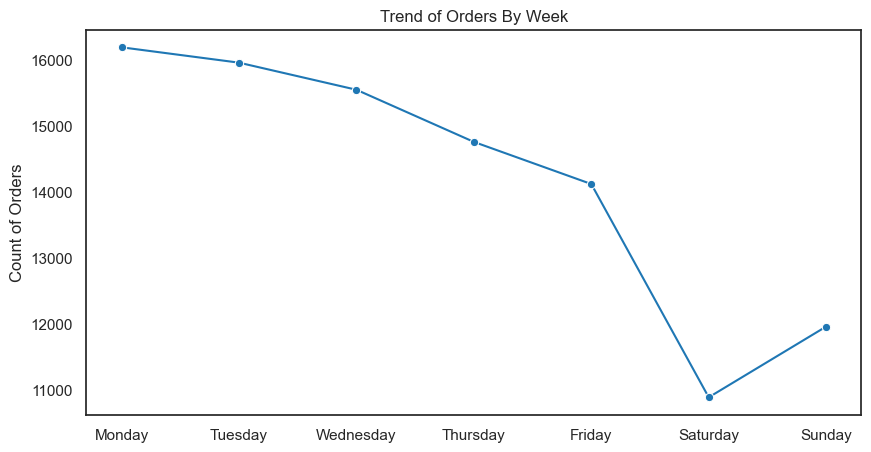

In [47]:
fig, ax = plt.subplots()
sns.set_style("white")  
days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
orders_day = customer_orders
orders_day["weekday"] = pd.Categorical(
    pd.to_datetime(orders_day['order_purchase_timestamp']).dt.day_name(),
    categories=days_order,
    ordered=True
)
orders_day = (
    orders_day
    .groupby('weekday')
    .agg({'order_id':'nunique'})
    .reset_index()
    .rename(columns={'weekday':'day'})
)
sns.lineplot(orders_day, x = "day", y="order_id", marker= "o")
plt.ylabel("Count of Orders")
plt.xlabel("")
plt.title("Trend of Orders By Week")
plt.show()

**17.4 Relation Between Customers and Order Trend**

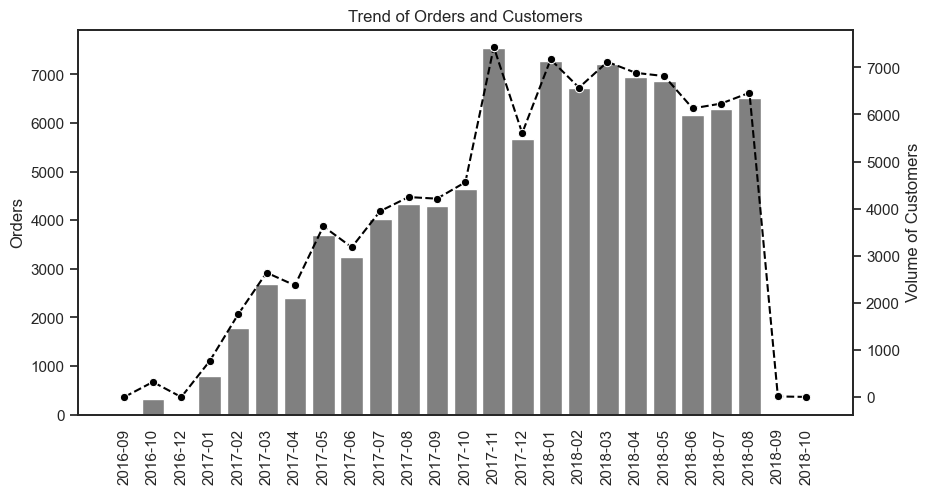

In [51]:
def groupbyMonth(dataFrame, col1, col2, period:str, operation):
    
    dataFrame = dataFrame.groupby(
        
        pd.to_datetime(dataFrame[col1]).dt.to_period(period)
    ).agg({col2:operation}).reset_index(names='month')
    dataFrame = pd.DataFrame(dataFrame)
    return dataFrame


count_of_customers_new = groupbyMonth(customer_orders, "order_purchase_timestamp", "customer_unique_id", "M", "nunique")
count_of_orders_new = groupbyMonth(customer_orders, "order_purchase_timestamp", "order_id", "M", "nunique")
customer_orders_merged =  count_of_customers_new.merge(count_of_orders_new[['month', 'order_id']], on= 'month', how= 'inner')
customer_orders_merged["cvr"] = np.round(customer_orders_merged["order_id"]/customer_orders_merged["customer_unique_id"],2)
customer_orders_merged["month"] = customer_orders_merged["month"].astype(str)


fig, ax1 = plt.subplots(figsize =(10,5))


sns.barplot(
    customer_orders_merged, x= "month", y="order_id",
    ax = ax1,
    color =  "gray")

ax2 = ax1.twinx()

sns.lineplot(customer_orders_merged, x= "month", y="customer_unique_id",
    ax = ax2,
    color =  "black",
    marker = "o",
    linestyle= "--" )

ax1.set_xlabel("")
ax1.set_ylabel("Orders")
ax2.set_ylabel("Volume of Customers")
ax1.tick_params(axis = "x", rotation=90)
plt.title("Trend of Orders and Customers")
plt.show()


**17.5 Relation Between Volume of Customers and Avg Rate of Order per Person**

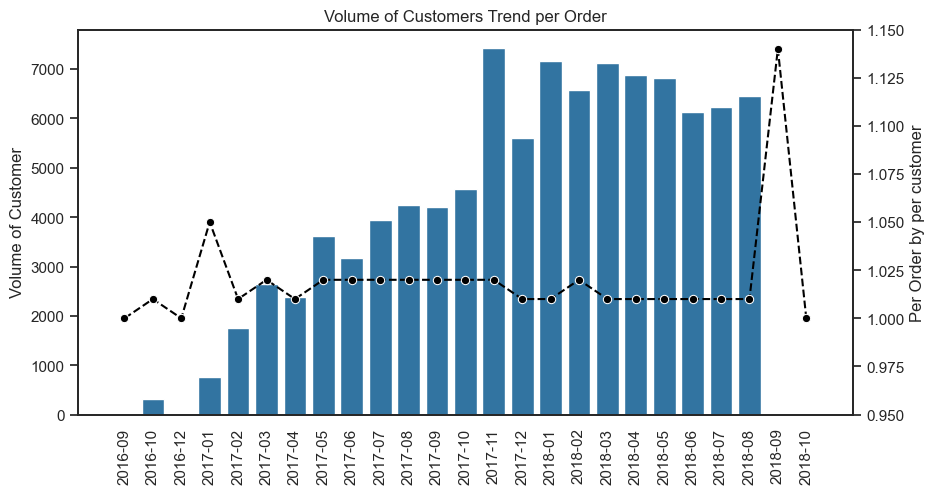

In [ ]:


fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(
    data=customer_orders_merged,
    x="month",
    y="customer_unique_id",
    ax=ax1
)

ax2 = ax1.twinx()

sns.lineplot(
    data=customer_orders_merged,
    x="month",
    y="cvr",
    ax = ax2,
    color =  "black",
    marker = "o",
    linestyle= "--"
)

ax2.set_ylim(0.95, 1.15) 
ax1.tick_params(axis= 'x', rotation = 90 ) 
ax1.set_ylabel("Volume of Customer")
ax2.set_ylabel("Per Order by per customer")
ax1.set_xlabel("")
plt.title("Volume of Customers Trend per Order")
plt.show()
# viz

**17.5 Orders by Quarter**

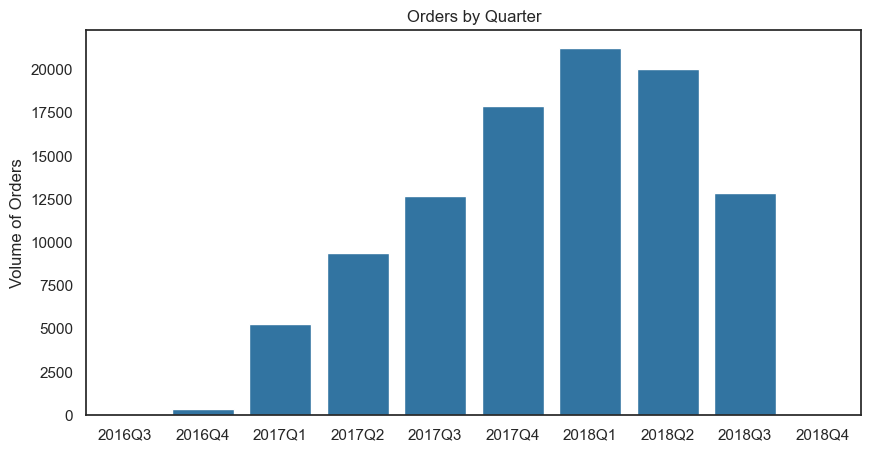

In [53]:
fig, ax = plt.subplots()
sns.set_style("white")  
quarter_group = groupbyMonth(customer_orders_merged, "month", "order_id", "Q", "sum")
quarter_group = pd.DataFrame(quarter_group)
quarter_group["month"] = quarter_group["month"].astype(str)
sns.barplot(quarter_group, x= "month", y = "order_id")
plt.ylabel("Volume of Orders")
plt.xlabel("")
plt.title("Orders by Quarter")
plt.show()

**17.6 Weekly Trend of Q3 for 2018**

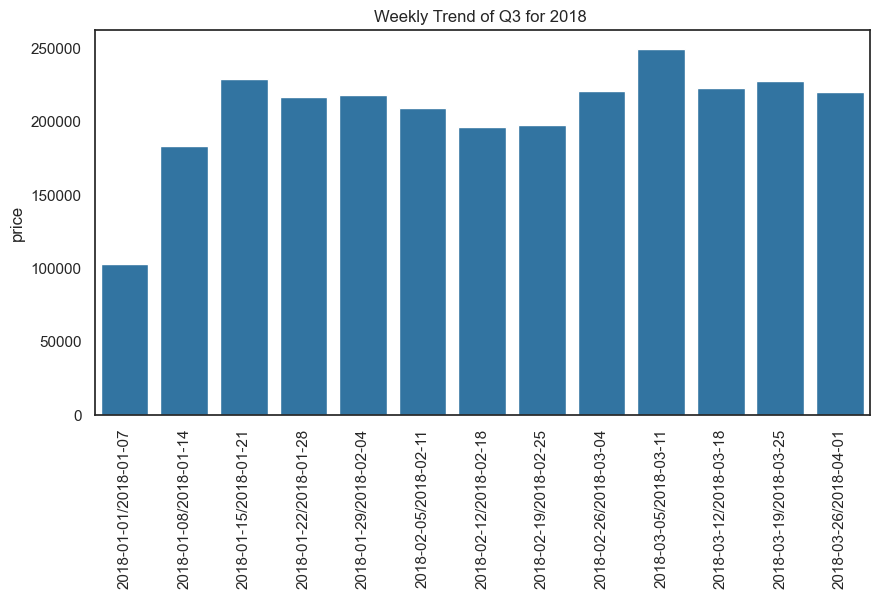

In [54]:
order_items_2018_Q3 = order_items[(order_items["shipping_limit_date"]>= '2018-01-01') & (order_items["shipping_limit_date"]<= '2018-03-31') ]
grouped_orders_18_Q3  = order_items_2018_Q3.merge(products[["product_id", "product_category_name"]], how="inner")

fig = figsize=(10,9)

grouped_orders_18_Q3["shipping_limit_date"] = pd.to_datetime(grouped_orders_18_Q3["shipping_limit_date"]).dt.strftime(("%Y-%m-%d"))



grouped_orders_18_Q3_2 = groupbyMonth(grouped_orders_18_Q3, "shipping_limit_date", "price", "W", "sum")


sns.barplot(grouped_orders_18_Q3_2, x = 'month', y ='price')
plt.tick_params(axis= 'x', rotation= 90)
plt.title("Weekly Trend of Q3 for 2018 ")
plt.xlabel("")
plt.show()


**17.7 Top 5 Categories Product for 2018 Q1**

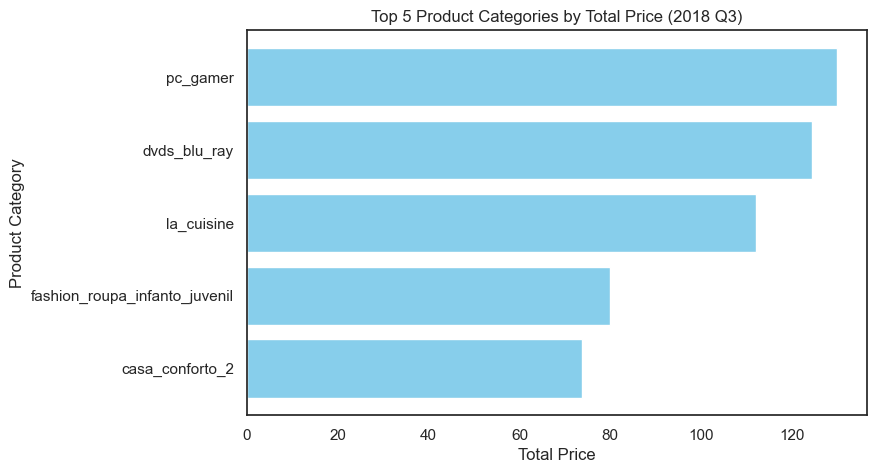

In [55]:
x = grouped_orders_18_Q3.groupby(grouped_orders_18_Q3['product_category_name']).agg({'price':'sum'}).reset_index(names ="category")
x_sorted = x.sort_values("price", ascending=True)

# Sort and take Top 5
x_top5 = x.sort_values("price", ascending=True).head(5)

# Horizontal bar chart
plt.figure(figsize=(8,5))
plt.barh(x_top5["category"], x_top5["price"], color="skyblue")

plt.xlabel("Total Price")
plt.ylabel("Product Category")
plt.title("Top 5 Product Categories by Total Price (2018 Q3)")
plt.show()

## 18. Insights & Conclusions

### Key Findings

#### Product & Category Insights
- A few **product categories dominate** order counts.  
- **Niche categories** may have a higher **average order value (AOV)**.  
- **High-value orders (top 10%)** cluster in specific categories → targeting them can improve revenue.  
- **High value spenders**: tend to buy **fixed_telephony** products.  
- **Low value spenders**: buy mostly from **bed_bath_table** and **health_beauty** → bundle/suggest these.  
- **Medium value spenders**: prefer **computers_accessories**, **computers**, and **drinks** → bundle computers + accessories.  
- **Medium spenders’ frequency** peaks at 10 orders; focusing on **3–6 visits** can increase engagement.  
- Categories like **furniture, computers, sports** show longer delivery times, while **beauty and gifts** are faster.  

#### Pricing & Payments
- **Price and freight** show a **positive correlation** (higher-priced items → higher freight).  
- **Payment type mix** varies by category.  
- **Credit_card** and **boleto** dominate usage → more targeted offers should be made available for these.  

#### Customer Demographics
- **Younger audiences (<25, 25–34):** purchase more frequently but with **lower AOV** → focus on **fashion/electronics**.  
- **Older audiences (35–44, 45+):** purchase less frequently but spend **more per order** → focus on **home & lifestyle**.  

#### Geography & Seasonality
- States **São Paulo (SP)** and **Rio de Janeiro (RJ)** lead in purchase volume.  
- Some states with fewer orders have **higher AOV**, indicating potential **premium markets**.  
- **Monthly trends** reveal clear **seasonality (peaks & troughs)** → optimize **promotion timing**.  

#### Delivery Performance
- Olist has **overall good delivery performance**, with only a minority of late deliveries.  
- However, **60%+ of late deliveries** were delayed by **more than 4 days**.  
- **~80% of delays** occur at the **carrier stage**, while ~20% are due to **seller delays**.  
- **Customer reviews drop sharply** when deliveries are late:  
  - **On-time:** ~4.3 stars  
  - **Late:** ~2.6 stars  
- A subset of sellers shows consistently **high late-delivery percentages** → requires monitoring.  

#### Seasonality & Timing

- **Monthly Order Peaks:**  
  - The highest monthly order volumes occurred in **November 2017** and **December 2017**, with over **9,000 orders** each month, compared to the median monthly volume of ~5,000 orders.
  - The top 5 months by order count contributed nearly **25% of total orders** in the 3-year period.
  - **Q4 (Oct–Dec)** consistently shows the strongest sales, suggesting holiday and year-end campaigns are highly effective.

- **Quarterly Trends:**  
  - **Q4** (Oct–Dec) accounts for **30–35% of annual orders**, while **Q1** (Jan–Mar) is typically the slowest, with order volumes dropping by **15–20%** compared to Q4.
  - Revenue follows a similar pattern, peaking in Q4 and dipping in Q1.

- **Weekly Patterns:**  
  - Orders are highest on **Mondays and Tuesdays**, averaging **1,500–1,700 orders** per day, while weekends (Saturday/Sunday) see a drop to **1,000–1,200 orders**.
  - This suggests marketing emails and promotions are most effective when launched at the start of the week.

- **Above-Median Months:**  
  - Out of 36 months, only **10 months** had order volumes above the median, indicating strong seasonality and the importance of targeted campaigns during peak periods.

---

### Recommendations

#### Product & Category
- Create **bundled offers** for categories that customers often buy together:  
  - **Computers + accessories**  
  - **Bed_bath_table + health_beauty**  
- Expand product availability in **fixed_telephony** for high-value spenders.  
- Promote **furniture, computers, sports** categories with better **delivery guarantees** to offset longer lead times.  

#### Pricing & Payments
- Offer **discounts or free freight thresholds** for higher-priced items (since freight correlates with price).  
- Enhance **checkout experience** by prioritizing **credit_card and boleto** payment flows.  
- Design targeted **payment-type promotions** (e.g., cashback on boleto, EMI on credit cards).  

#### Customer Demographics
- **Younger audiences (<25, 25–34):** Push **frequent purchase categories** like **fashion/electronics** with **flash sales**.  
- **Older audiences (35–44, 45+):** Position **premium home & lifestyle** products with **higher-ticket promotions**.  

#### Geography & Seasonality
- Focus marketing campaigns on **SP and RJ** (high volume).  
- Experiment with **premium-focused campaigns** in states with fewer orders but higher AOV.  
- Align **promotions with seasonal peaks** to capture demand surges.  

#### Delivery Performance
- Enforce **stricter SLAs** with carriers (responsible for ~80% of delays).  
- Monitor **sellers with consistently high late-shipment rates**.  
- Prioritize **fast-track delivery promises** for categories with historically slow delivery times.  
- Communicate expected delivery times transparently to maintain **customer trust and ratings**.  


#### Seasonality & Timing
**Align major promotions and inventory planning with Q4 peaks** to maximize sales.
  - **Launch flash sales and targeted ads early in the week** to capture higher weekday demand.
  - **Prepare for slower Q1 periods** by introducing loyalty programs or bundled offers to stimulate demand.
  - **Monitor monthly and weekly trends** to adjust marketing spend and stock levels dynamically.
  - **Leverage historical peak months** (e.g., November/December) for new product launches and aggressive discounting.


---
  
